In [1]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import random
import math
import cv2


In [2]:
from collections import namedtuple
Circle = namedtuple('Circle', ['x', 'y', 'r', 'O', 'c'])
Rectangle = namedtuple('Rectangle', ['x', 'y', 'k', 'a', 'b', 'O', 'c'])
# x & y : any float (location of center of the obstacle)
# r: radius of circle
# k: angle of the rectangle (0 to pi/2)
# a, b: sides of the rectangle
# O, c: opacity and color of the obstacle

# color_map, polar_map -> uint8 array
# opacity_map -> bool array

class actor:
    def __init__(self, map_size, initial_location = None):
        self.map_size = map_size
        self.opacity_map = np.full((map_size, map_size), False)
        self.color_map = np.zeros([map_size, map_size], dtype = np.uint8);
        self.initial_location = initial_location if (initial_location != None) else (int(map_size/2),int(map_size/2))
        self.Y,self.X = np.meshgrid(np.linspace(1, self.map_size ,self.map_size),np.linspace(1, self.map_size ,self.map_size))
        self.x = int(map_size/2)
        self.y = int(map_size/2)
        self.polar_angle_size = 256
        self.polar_dist_size = 256
        self.n_circles = 20
        self.n_rectangles = 20
        self.polar_map = np.zeros([self.polar_dist_size, self.polar_angle_size], dtype = np.uint8)
        self.view = np.zeros([self.polar_angle_size])
        self.depth = np.zeros([self.polar_angle_size])
    def initialize_terrain(self):
        A = [Circle(x = random.randrange(0, self.map_size), 
                    y = random.randrange(0, self.map_size), 
                    r = random.randrange(0, int(self.map_size/2)), 
                    O = bool(random.getrandbits(1)), 
                    c = random.randrange(0, 255)) for i in range(self.n_circles)]
        A += [Rectangle(x = random.randrange(0, self.map_size), 
                        y = random.randrange(0, self.map_size), 
                        k = random.uniform(0, math.pi/2), 
                        a = random.uniform(0, self.map_size), 
                        b = random.uniform(0, self.map_size), 
                        O = bool(random.getrandbits(1)), 
                        c = random.randrange(0, 255)) for j in range(self.n_rectangles)]
        self.generate_terrain(A)
    def generate_terrain(self, A):
        for i in A:
            if type(i).__name__ == 'Circle':
                mask = self.circular_obstacle(i)
            elif type(i).__name__ == 'Rectangle':
                mask = self.rectangular_obstacle(i)
            if not (mask & (self.circular_obstacle(Circle(x = self.x, y = self.y, r = 16, O = True, c = 255)).astype(bool))).any():
                if i.O:
                    self.opacity_map = np.logical_or(mask, self.opacity_map)
                    self.color_map = self.color_map*(~mask)+(i.c*mask).astype(np.uint8)
                else:
                    self.opacity_map = np.logical_and(~mask, self.opacity_map)
                    self.color_map = self.color_map*(~mask)
    def generate_view(self):
        self.padded_map = cv2.copyMakeBorder(self.color_map, self.map_size*2, self.map_size*2, self.map_size*2, self.map_size*2, cv2.BORDER_CONSTANT, 0)
        self.polar_map = cv2.warpPolar(self.padded_map, self.polar_map.shape, (self.map_size*2+self.x,self.map_size*2+self.y), 256, flags = cv2.INTER_NEAREST+cv2.WARP_POLAR_LINEAR)
        mask = self.polar_map!=0
        self.depth = np.where(mask.any(axis=1), mask.argmax(axis=1), 0)
        self.view = self.polar_map[np.arange(self.polar_angle_size), self.depth]
    def circular_obstacle(self, i):
        return (self.X-i.x)**2 + (self.Y-i.y)**2 <= i.r**2
    def rectangular_obstacle(self, i):
        return  np.logical_and((np.abs((self.X-i.x)/(np.cos(i.k)+0.001)-(self.Y-i.y)/(np.sin(i.k)+0.001)))<=(i.a*np.abs(np.tan(i.k)+1/(np.tan(i.k)+0.001))/2),
                               (np.abs((self.X-i.x)/(np.sin(i.k)+0.001)+(self.Y-i.y)/(np.cos(i.k)+0.001)))<=(i.b*np.abs(np.tan(i.k)+1/(np.tan(i.k)+0.001))/2))



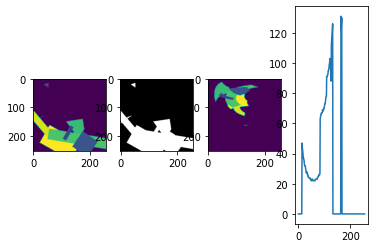

In [3]:
a = actor(256)
A = [Rectangle(x = 50, y = 40, k = 0.5, a = 40, b = 40, O = True, c = 80),
     Rectangle(x = 80, y = 20, k = 0.0, a = 40, b = 40, O = False, c = 28),
     Rectangle(x = 180, y = 90, k = 0.8, a = 100, b = 10, O = True, c = 50),
     Circle(x = 130, y = 230, r = 80, O = True, c = 30),
     Circle(x = 100, y = 90, r = 40, O = True, c = 200),
     Circle(x = 30, y = 130, r = 20, O = True, c = 50),]
a.initialize_terrain()
plt.subplot(1,4,1)
plt.imshow(a.color_map)
plt.subplot(1,4,2)
plt.imshow(a.opacity_map, cmap='gray')
plt.subplot(1,4,3)

a.generate_view()
plt.imshow(a.polar_map)
plt.subplot(1,4,4)
plt.plot(a.depth)
plt.show()

<IPython.core.display.Javascript object>


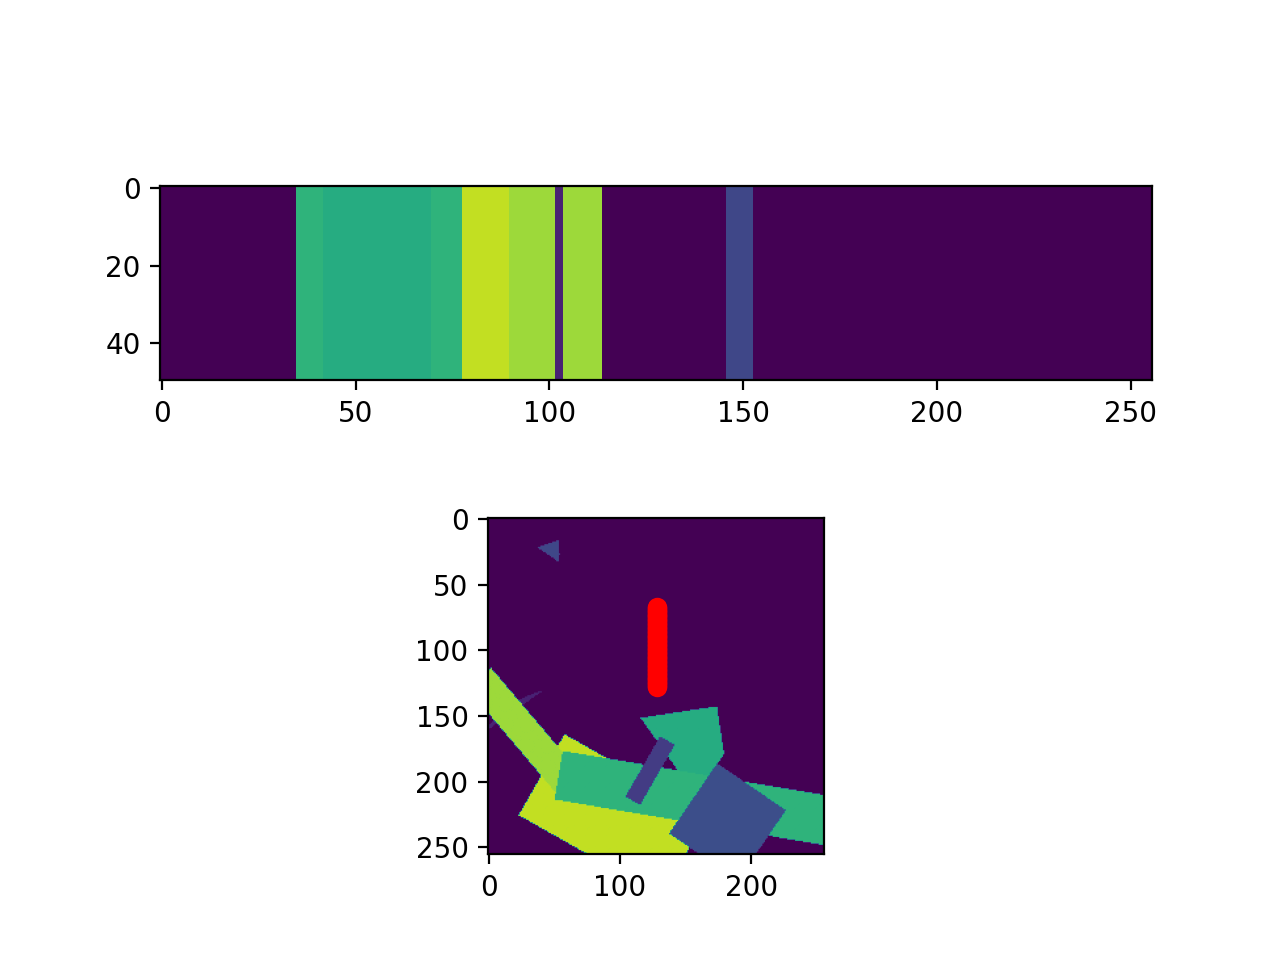

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0 158 158 158 158
 158 158 158 158 158 158 158 158 158 158 158 158 158 158 158 158 158 158
 158 158 158 158 158 158 158 158 158 158 158 158 158 158 158 158 158 158
 158 158 158 158 158 158 158 158 158 158 158 158 158 158 158 158 158 158
 158 158 158 158 158 158 158 158 158 158 158 158 166 166 166 166 166 166
 232 232 232 232 232 232 232 232 232 232 232 232 232 232 232 232 232 232
 232 218 218 218 218 218 218 218 218 218 218 218 218 218 218  24  24  24
  24 218 218 218 218 218 218   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0  54  54  54  54   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

In [4]:
from matplotlib.animation import FuncAnimation
%matplotlib notebook
fig = plt.figure()
plt.subplot(2,1,1)
im1 = plt.imshow(np.tile(a.view.reshape(1,256), (50,1)), vmin=0, vmax=256)
print(a.view)
plt.subplot(2,1,2)
im2 = plt.imshow(a.color_map, vmin=0, vmax=256)
pos = plt.scatter([a.x],[a.y],color='r')
              
def init():
    plt.subplot(2,1,1)
    im1 = plt.imshow(np.tile(a.view.reshape(1,256), (50,1)), vmin=0, vmax=256)
    plt.subplot(2,1,2)
    pos = plt.scatter([a.x],[a.y],color='r')
    return [im1]

def animate(frame_num):
    if a.y < a.map_size and a.y >= 0:
        a.y-=1
    a.generate_view()
    plt.subplot(2,1,1)
    im1 = plt.imshow(np.tile(a.view.reshape(1,256), (50,1)), vmin=0, vmax=256)
    plt.subplot(2,1,2)
    pos = plt.scatter([a.x],[a.y],color='r')
    return [im1, pos]
                
anim = FuncAnimation(fig, animate, frames=100, interval=1)
plt.show()

In [5]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as f

In [6]:
class Nerf_Model(nn.Module):
    def __init__(self, map_size, view_size):
        super().__init__()
        self.occupancy = nn.Sequential(nn.Linear(32, 64),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(64, 64),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(64, 64),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(64, 64),
                                       nn.ReLU(inplace=True),
                                       nn.Linear(64, 65),
                                       nn.ReLU(inplace=True))
        self.color = nn.Sequential(nn.Linear(64,32),
                                   nn.ReLU(inplace=True),
                                   nn.Linear(32, 1),
                                   nn.Sigmoid())
        self.map_size = map_size
        self.view_size = view_size
    
    def forward(self, p):
        X = self.positional_encoder(p)
        X = self.occupancy(X)
        o = X[:,:1]
        c = self.color(X[:,1:])
        return torch.cat([o, c], dim = 1)
        
        
    def positional_encoder(self, P):
        P = P.reshape((-1, 2, 1)).tile(1,1,8)
        w = 2 ** torch.linspace(0, 7, steps=8).tile(P.shape[0],2,1)
        P *= math.pi * w
        P = torch.cat([torch.cos(P), torch.sin(P)], dim = 2)
        return P.reshape(P.shape[0],-1)
        
M = Nerf_Model(256, 256);
print(M(torch.tensor([[0.28, 0.382], [0.01,0.01],[0, 0],[0, 0],[0.01,0.01]])))

tensor([[0.0000, 0.4565],
        [0.0000, 0.4563],
        [0.0000, 0.4560],
        [0.0000, 0.4560],
        [0.0000, 0.4563]], grad_fn=<CatBackward>)


tensor([[0.3101, 0.3101],
        [0.3234, 0.3234],
        [0.3509, 0.3509],
        [0.3652, 0.3652],
        [0.3825, 0.3825],
        [0.3952, 0.3952],
        [0.4208, 0.4208],
        [0.4357, 0.4357],
        [0.4516, 0.4516],
        [0.4688, 0.4688],
        [0.4872, 0.4872],
        [0.5081, 0.5081],
        [0.5164, 0.5164],
        [0.5399, 0.5399],
        [0.5514, 0.5514],
        [0.5711, 0.5711],
        [0.5855, 0.5855],
        [0.6098, 0.6098],
        [0.6269, 0.6269],
        [0.6424, 0.6424],
        [0.6604, 0.6604],
        [0.6799, 0.6799],
        [0.6982, 0.6982],
        [0.7114, 0.7114],
        [0.7301, 0.7301],
        [0.7501, 0.7501],
        [0.7690, 0.7690],
        [0.7854, 0.7854],
        [0.7956, 0.7956],
        [0.8188, 0.8188],
        [0.8372, 0.8372],
        [0.8451, 0.8451],
        [0.8718, 0.8718],
        [0.8841, 0.8841],
        [0.8991, 0.8991],
        [0.9181, 0.9181],
        [0.9330, 0.9330],
        [0.9624, 0.9624],
        [0.9

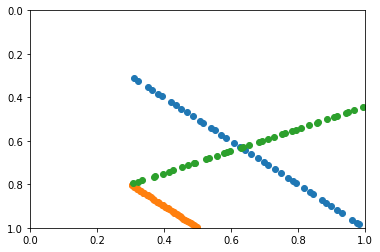

In [8]:
N = 40

#ray point sampling


def end_point(p, a):
    r = 2 * math.pi * (a+0.25)
    smooth = 10**-6
    x = p[:,0]
    y = p[:,1]
    T = torch.stack([x/(-torch.sin(r)+smooth), 
                     y/(torch.cos(r)+smooth), 
                     (1-x)/(torch.sin(r)+smooth), 
                     (1-y)/(-torch.cos(r)+smooth)])
    T = torch.min(torch.where(T>=0, T, 10*torch.ones(T.shape)), 0)[0]
    return torch.stack([x + T * torch.sin(r), y - T * torch.cos(r)]).T

def rand_samp(p):
    p, a = p[:,:2], p[:,2]
    p_e = end_point(p, a)
    p_e = p_e[:,:2]
    p_i = torch.linspace(0, N-1, N)
    p_i = p_i.reshape((1, N, 1)) * (p_e-p).reshape((p.shape[0], 1, 2)) / N
    randn = torch.rand(p.shape[0],N)
    p_i = p_i + randn.reshape((p.shape[0],N,1)) * (p_e-p).reshape((p.shape[0], 1, 2)) / N
    return p_i + p.reshape(p.shape[0],1,2)

p = rand_samp(torch.tensor([[0.3,0.3,0.125], [0.3,0.8,0.125],[0.3,0.8,0.925], [0.3,0.8,0.925]]))
print(p[0])
plt.scatter(p[0,:,0],p[0,:,1])
plt.scatter(p[1,:,0],p[1,:,1])
plt.scatter(p[2,:,0],p[2,:,1])
plt.xlim(0,1)
plt.ylim(1,0)
plt.show()

In [9]:
# p: [[c,x,y,r],...[c,x,y,r]]
criterion = nn.MSELoss()
def photo_loss(model, p):
    rand_points = rand_samp(p[:,1:])
    output = model(torch.squeeze(rand_points,dim = 1)).reshape((-1, N, 2))
    dists = (torch.roll(rand_points, -1, 1) - torch.roll(rand_points, 1, 1))/2
    dists[:,0,:] = (rand_points[:,-1]-rand_points[:,0])/(rand_points.shape[1]-1)
    dists[:,-1,:] = (rand_points[:,-1]-rand_points[:,0])/(rand_points.shape[1]-1)
    dist = (dists[:,:,0]**2 + dists[:,:,1]**2)**0.5
    sigma = torch.tril(torch.ones((N,N)),diagonal=-1)
    T = torch.exp(-torch.matmul(sigma, (output[:,:,0]*dist).T).T)
    #print(T)
    C = T * (1 - torch.exp(-output[:,:,0] * dist)) * output[:,:,1]
    #print(output[:,:,1])
    C = torch.sum(C, dim = 1)
    loss = criterion(C, p[:,0])
    #print(C)
    return loss
photo_loss(M,torch.tensor([[0.1,0.3,0.3,0.125],[0.1,0.3,0.8,0.125],[0.1,0.3,0.8,0.125]]))

tensor(0.0100, grad_fn=<MseLossBackward>)

In [10]:
a = torch.tensor([[0.,0.,0.,0.],[0.5,0.5,0.5,0.5],[0.5,0.5,0.5,0.5]])
photo_loss(M, a)

tensor(0.1667, grad_fn=<MseLossBackward>)

In [11]:
def gen_viewpoints(actor, n_sample):
    samplecount = 0
    viewpoints = torch.tensor([])
    while samplecount < n_sample:
        actor.x, actor.y = random.randint(0, actor.map_size-1), random.randint(0, actor.map_size-1)
        if actor.opacity_map[a.x,a.y] == False:
            samplecount += 1
            actor.generate_view()
            view = torch.cat([torch.from_numpy(actor.view.reshape((-1,1)))/256, 
                                torch.tensor([a.x]).expand(256,1)/256, 
                                torch.tensor([a.y]).expand(256,1)/256, 
                                torch.linspace(0,1,256).reshape(256,1)], dim = 1)
            viewpoints = torch.cat([viewpoints, view], dim = 0)
    return viewpoints

def train(model, n, n_batch, p, optim):
    optim.zero_grad()
    #print(torch.index_select(p, 0, torch.randint(0, p.shape[0], (n_batch,))))
    loss = photo_loss(model, torch.index_select(p, 0, torch.randint(0, p.shape[0], (n_batch,))))
    loss.backward()
    optim.step()
    return loss.item()


In [12]:
import wandb

wandb.init(project="Robovision", entity="gyungmin")

wandb: Currently logged in as: gyungmin (use `wandb login --relogin` to force relogin)


In [13]:
learning_rate = 1*10**-5
n_epoch = 100000
model = Nerf_Model(256, 256)
optim = torch.optim.Adam(model.parameters(), lr = learning_rate)

a = actor(256);
a.initialize_terrain()


model.train()
for i in range(n_epoch):
    p = gen_viewpoints(a, 64)
    loss = train(model, 1, 400, p, optim)
    print(loss)
    wandb.log({"loss": loss})



0.09772853553295135
0.09982460737228394
0.11525212973356247
0.08085135370492935
0.08349502831697464
0.10145387053489685
0.11851079761981964
0.08315615355968475
0.08833450078964233
0.10167514532804489
0.09061653912067413
0.13820023834705353
0.0972059816122055
0.09403480589389801
0.08957645297050476
0.09536349028348923
0.08751730620861053
0.09291186183691025
0.09942535310983658
0.1012977808713913
0.09141192585229874
0.1028396412730217
0.08485022187232971
0.10734830796718597
0.09617922455072403
0.08872825652360916
0.09771160781383514
0.0937884971499443
0.10507172346115112
0.09255748987197876
0.10138159990310669
0.09378320723772049
0.07617808133363724
0.12367681413888931
0.09106942266225815
0.08167728781700134
0.08187570422887802
0.07552741467952728
0.09258286654949188
0.08167468756437302
0.07346797734498978
0.08463966101408005
0.08448901772499084
0.1036922037601471
0.09890922904014587
0.08796814829111099
0.08666710555553436
0.09544017910957336
0.09572343528270721
0.0888761356472969
0.0960

0.06928440928459167
0.09123960137367249
0.08244886994361877
0.06724439561367035
0.08499714732170105
0.0808180421590805
0.07445389032363892
0.09550724923610687
0.09449274837970734
0.07800460606813431
0.09802205115556717
0.07015429437160492
0.07525575906038284
0.07463808357715607
0.09686721116304398
0.07655617594718933
0.08738347887992859
0.0693192183971405
0.09377384185791016
0.1057501956820488
0.07045511901378632
0.09470374137163162
0.10196740925312042
0.09818407148122787
0.08632323890924454
0.06649386882781982
0.08850503712892532
0.11046627908945084
0.0817173421382904
0.08689260482788086
0.08244797587394714
0.09084374457597733
0.08021135628223419
0.06334188580513
0.09116354584693909
0.08483464270830154
0.10569169372320175
0.07113049179315567
0.07932331413030624
0.07661272585391998
0.07869024574756622
0.1139325350522995
0.08047131448984146
0.09035977721214294
0.06772276759147644
0.06641824543476105
0.051918286830186844
0.07597082108259201
0.060253921896219254
0.08089273422956467
0.0853

0.07796721160411835
0.05816219747066498
0.055906835943460464
0.0626935213804245
0.06359663605690002
0.07945051044225693
0.06431411951780319
0.06673002243041992
0.07832877337932587
0.05915861204266548
0.06735186278820038
0.0700417160987854
0.06862280517816544
0.06793923676013947
0.06314095109701157
0.05110977962613106
0.07671372592449188
0.046442750841379166
0.06692007184028625
0.09021663665771484
0.07096417248249054
0.08135444670915604
0.06842225790023804
0.06954044103622437
0.07541681081056595
0.0739544928073883
0.07149653881788254
0.059691961854696274
0.0762975811958313
0.0534915067255497
0.08152975887060165
0.07682949304580688
0.0610882006585598
0.0759383887052536
0.05771632492542267
0.07457363605499268
0.06608962267637253
0.06176640838384628
0.08024913817644119
0.07624933868646622
0.06108895689249039
0.061358287930488586
0.06417408585548401
0.06822210550308228
0.09774412959814072
0.083214171230793
0.07806558161973953
0.06343349814414978
0.09393715858459473
0.0663842111825943
0.0799

0.05251140519976616
0.04565190151333809
0.04855652153491974
0.053532060235738754
0.05956175923347473
0.04587665945291519
0.044509679079055786
0.04160994663834572
0.041776143014431
0.04760408774018288
0.05966369807720184
0.05236775428056717
0.03898094967007637
0.040170181542634964
0.04374999180436134
0.05313306301832199
0.03205079957842827
0.05266011133790016
0.06281568855047226
0.048736996948719025
0.055927928537130356
0.04661111533641815
0.05490690842270851
0.0600893460214138
0.03919236734509468
0.0430341400206089
0.043249111622571945
0.04812838137149811
0.05749271437525749
0.04135539010167122
0.0616455078125
0.05280771851539612
0.05408492684364319
0.061088550835847855
0.025212716311216354
0.04188300669193268
0.048974085599184036
0.0436272919178009
0.055490151047706604
0.059412892907857895
0.056246183812618256
0.056538138538599014
0.04938114061951637
0.04232259839773178
0.042406488209962845
0.0524175651371479
0.04064374044537544
0.052587494254112244
0.059766605496406555
0.035703469067

0.051065340638160706
0.04135528579354286
0.045796021819114685
0.04727103188633919
0.04596452787518501
0.054287876933813095
0.03527561202645302
0.042542964220047
0.05953347310423851
0.046038560569286346
0.04869750514626503
0.04831521958112717
0.05687456950545311
0.036849964410066605
0.04136132076382637
0.04932435601949692
0.05149349570274353
0.04669339209794998
0.04910234361886978
0.0368470661342144
0.03881902992725372
0.04407738521695137
0.057715870440006256
0.05378733575344086
0.038565266877412796
0.04319927841424942
0.05588266998529434
0.03666016086935997
0.048540305346250534
0.04280179366469383
0.03620488569140434
0.04548441991209984
0.049897972494363785
0.04126742482185364
0.05224847421050072
0.0462544709444046
0.0493747815489769
0.04339887946844101
0.0471106581389904
0.04774104058742523
0.047911375761032104
0.04400840774178505
0.04452945664525032
0.04770118370652199
0.044790927320718765
0.05002041161060333
0.06149087846279144
0.05134795233607292
0.05385458841919899
0.0370817929506

0.04411870613694191
0.03835529088973999
0.03943517059087753
0.03951609134674072
0.044211555272340775
0.03866243734955788
0.044802576303482056
0.0465192086994648
0.050389185547828674
0.04519866034388542
0.040980882942676544
0.04847446456551552
0.04799848422408104
0.03883632645010948
0.05147511512041092
0.040574636310338974
0.043600987643003464
0.04954603314399719
0.053954120725393295
0.04473617672920227
0.04279186204075813
0.057226959615945816
0.049312371760606766
0.04155866056680679
0.044070810079574585
0.03968918323516846
0.040248412638902664
0.04114135354757309
0.04226016625761986
0.05889308452606201
0.04824495315551758
0.03835318237543106
0.046628694981336594
0.0404268279671669
0.04163755103945732
0.05707922577857971
0.03812578320503235
0.044203296303749084
0.04691420868039131
0.04423031955957413
0.052850402891635895
0.042641788721084595
0.03906384855508804
0.038493238389492035
0.03768310695886612
0.04604528471827507
0.04008178785443306
0.04753176122903824
0.04079229012131691
0.0391

0.04475753381848335
0.04938926547765732
0.04157167300581932
0.03509343042969704
0.044565893709659576
0.03921079263091087
0.04034977778792381
0.053526539355516434
0.04988400638103485
0.04568605124950409
0.04459455609321594
0.0463024340569973
0.04322259500622749
0.047217026352882385
0.044183600693941116
0.04079893231391907
0.03968352451920509
0.04670184478163719
0.038983650505542755
0.037113744765520096
0.04296154901385307
0.047638606280088425
0.044680431485176086
0.04816146939992905
0.038912296295166016
0.05056379735469818
0.03748432919383049
0.03621499985456467
0.047978032380342484
0.03938603401184082
0.04302763566374779
0.04890268296003342
0.04284783452749252
0.03745449706912041
0.041543640196323395
0.04718402028083801
0.04959454387426376
0.04785005748271942
0.04853609949350357
0.04899315908551216
0.03920770809054375
0.037957463413476944
0.04593072831630707
0.040463656187057495
0.047608934342861176
0.03697508946061134
0.042424701154232025
0.05036948248744011
0.04080651327967644
0.0478

0.046220626682043076
0.04453461617231369
0.03881775960326195
0.04126998782157898
0.04392567649483681
0.04294932261109352
0.056779827922582626
0.03893839195370674
0.04602278396487236
0.03756667673587799
0.04989716410636902
0.047733549028635025
0.041316527873277664
0.03595350310206413
0.038893137127161026
0.04742872342467308
0.05150853469967842
0.03429824486374855
0.052085552364587784
0.04343068227171898
0.04118606075644493
0.043182309716939926
0.0380658395588398
0.04120670258998871
0.04871521517634392
0.04929392412304878
0.046472884714603424
0.043025899678468704
0.03892560675740242
0.03530341759324074
0.043563228100538254
0.04282600060105324
0.04730018228292465
0.0392887145280838
0.03863072767853737
0.037712011486291885
0.047011084854602814
0.04911039024591446
0.04927504062652588
0.03654402121901512
0.04183625802397728
0.04497415944933891
0.04170865938067436
0.0348106324672699
0.04670880734920502
0.044277552515268326
0.05062811076641083
0.04106032848358154
0.035186778753995895
0.0398256

0.04372844099998474
0.04469885677099228
0.03946716710925102
0.03905167803168297
0.03612152487039566
0.044536419212818146
0.036688610911369324
0.03410106524825096
0.03937802463769913
0.03598601371049881
0.036152176558971405
0.04329003021121025
0.041718076914548874
0.04662107303738594
0.0385943204164505
0.04443025588989258
0.0355636328458786
0.03223588690161705
0.04468941316008568
0.030470168218016624
0.04251290485262871
0.043341539800167084
0.03388947993516922
0.0397326834499836
0.04351864010095596
0.0402810238301754
0.033643342554569244
0.04315042495727539
0.041411615908145905
0.04231841117143631
0.045252781361341476
0.039344895631074905
0.04260474815964699
0.036979466676712036
0.039718497544527054
0.0407855398952961
0.04043895751237869
0.029200516641139984
0.028109755367040634
0.04201523959636688
0.03584199771285057
0.036014676094055176
0.03688442334532738
0.04595367610454559
0.052177026867866516
0.038235969841480255
0.03722941875457764
0.04295182228088379
0.036124855279922485
0.05018

0.043251145631074905
0.04331750422716141
0.028153153136372566
0.03990594670176506
0.040718723088502884
0.037554990500211716
0.029573677107691765
0.03594355657696724
0.042961593717336655
0.026403911411762238
0.0426158681511879
0.04734814167022705
0.04749187454581261
0.03807581961154938
0.04530853405594826
0.03338039293885231
0.04035721719264984
0.029132241383194923
0.03918946534395218
0.035207703709602356
0.04335648939013481
0.035673588514328
0.03268153965473175
0.04905323684215546
0.033599380403757095
0.051073212176561356
0.04047693312168121
0.029789339751005173
0.0405951589345932
0.039831262081861496
0.04146420583128929
0.036074116826057434
0.046154867857694626
0.03989625349640846
0.03629276156425476
0.042426660656929016
0.03345155715942383
0.03584488853812218
0.032011404633522034
0.043725255876779556
0.037418656051158905
0.02954898774623871
0.03973526880145073
0.03979248180985451
0.05068245902657509
0.04769979417324066
0.03751828148961067
0.039118897169828415
0.05609273910522461
0.04

0.0351514033973217
0.0291451308876276
0.03690719231963158
0.047260358929634094
0.03588861972093582
0.03343779966235161
0.03435501456260681
0.03168591484427452
0.04768452048301697
0.04017791152000427
0.06209154054522514
0.036726485937833786
0.0343809500336647
0.03404047340154648
0.029483549296855927
0.04187192767858505
0.031163573265075684
0.043668538331985474
0.037127599120140076
0.03854663670063019
0.029694758355617523
0.03863150253891945
0.03610032796859741
0.03648033365607262
0.034235477447509766
0.03900161385536194
0.03326961025595665
0.029914189130067825
0.03521350398659706
0.04377284646034241
0.03749090060591698
0.03807414695620537
0.03872596099972725
0.0350218303501606
0.04247959703207016
0.03357646241784096
0.037139300256967545
0.032737523317337036
0.03688247129321098
0.03255467861890793
0.0330764502286911
0.03607986122369766
0.04545528069138527
0.03641817718744278
0.033455539494752884
0.03241259977221489
0.04105775058269501
0.03373000770807266
0.030063286423683167
0.0354045256

0.04050905257463455
0.033349644392728806
0.03946017846465111
0.034647271037101746
0.031763628125190735
0.044758524745702744
0.029857881367206573
0.04730512946844101
0.033567868173122406
0.038727570325136185
0.03293156996369362
0.03321056067943573
0.03394120931625366
0.044424306601285934
0.03165140748023987
0.03215554356575012
0.03543213754892349
0.03695909306406975
0.037546880543231964
0.03359774127602577
0.03666626289486885
0.039169665426015854
0.02976544387638569
0.0414547435939312
0.03948916122317314
0.03959975764155388
0.034920986741781235
0.03171422332525253
0.04375144839286804
0.031727343797683716
0.038209374994039536
0.03382381796836853
0.041371699422597885
0.03447643294930458
0.030033428221940994
0.038623686879873276
0.03975573182106018
0.03996192291378975
0.037415653467178345
0.04432902857661247
0.042737189680337906
0.02994704805314541
0.030602438375353813
0.04626479744911194
0.03987701237201691
0.024731550365686417
0.04480033367872238
0.03795544058084488
0.036680370569229126


0.03511737659573555
0.031116126105189323
0.04494683817028999
0.04878360405564308
0.030021285638213158
0.05318127200007439
0.04141576588153839
0.03196396678686142
0.03964401036500931
0.04111475870013237
0.03458477556705475
0.033951595425605774
0.03259076178073883
0.03459225967526436
0.03508514165878296
0.04317726939916611
0.03454021364450455
0.03255990147590637
0.04031755402684212
0.03897950053215027
0.03535088151693344
0.04680323973298073
0.03940786048769951
0.043484076857566833
0.033047497272491455
0.03416797146201134
0.03820941597223282
0.03710735961794853
0.03554776310920715
0.037367310374975204
0.04788734391331673
0.03832757845520973
0.032064612954854965
0.03589406609535217
0.03170500695705414
0.03387709707021713
0.03306712955236435
0.03968149796128273
0.03890728950500488
0.03209594264626503
0.03977323696017265
0.02577975206077099
0.03625322878360748
0.03221290558576584
0.034013763070106506
0.04553841054439545
0.032213348895311356
0.033801816403865814
0.04410815238952637
0.03487459

0.027589542791247368
0.045065756887197495
0.050104908645153046
0.03619637340307236
0.03766617178916931
0.036744650453329086
0.029492823407053947
0.03835767135024071
0.02653888612985611
0.024859318509697914
0.0356772318482399
0.03199249505996704
0.03559151291847229
0.03881103917956352
0.037061482667922974
0.03727012127637863
0.02591664344072342
0.04806914180517197
0.03190553933382034
0.03566579520702362
0.03195161372423172
0.04124833643436432
0.03839189559221268
0.044514063745737076
0.03793172910809517
0.04044482111930847
0.030963117256760597
0.04320945218205452
0.03497298061847687
0.030053772032260895
0.03889128938317299
0.03573476895689964
0.02680588699877262
0.04387720674276352
0.027846598997712135
0.04960787668824196
0.047774963080883026
0.030944492667913437
0.04036973416805267
0.03190649300813675
0.03534737601876259
0.039672136306762695
0.032962363213300705
0.03396741300821304
0.04174935817718506
0.04371759295463562
0.0341387540102005
0.04041670635342598
0.04407661780714989
0.02893

0.04267415031790733
0.03306189551949501
0.03184773400425911
0.03829788789153099
0.033865079283714294
0.03816326707601547
0.03538823127746582
0.035698384046554565
0.03576626628637314
0.03655610606074333
0.037362128496170044
0.042610250413417816
0.03020479902625084
0.045069511979818344
0.02858622558414936
0.03402179107069969
0.0404641330242157
0.031414106488227844
0.032794490456581116
0.03849610313773155
0.02503817528486252
0.028054576367139816
0.03092842549085617
0.03115912526845932
0.028635084629058838
0.045001234859228134
0.032143063843250275
0.036777786910533905
0.033964578062295914
0.03228650614619255
0.032790407538414
0.031733956187963486
0.02422545850276947
0.034197136759757996
0.0352146252989769
0.035560157150030136
0.04540136456489563
0.034093525260686874
0.030583515763282776
0.041430097073316574
0.030798207968473434
0.035844847559928894
0.04026537016034126
0.036347612738609314
0.04056137427687645
0.03221637383103371
0.02693263813853264
0.03307906910777092
0.0387004092335701
0.0

0.03714817389845848
0.029752297326922417
0.03907549008727074
0.025343935936689377
0.04541848227381706
0.03608527034521103
0.0375506766140461
0.033997006714344025
0.029860209673643112
0.038437142968177795
0.028149807825684547
0.043359506875276566
0.030977904796600342
0.031688492745161057
0.03117193467915058
0.03498295694589615
0.036398645490407944
0.033115778118371964
0.03867139294743538
0.035621222108602524
0.035029731690883636
0.035932935774326324
0.03082151710987091
0.030796078965067863
0.032863788306713104
0.02945268154144287
0.031591154634952545
0.024196546524763107
0.03130708262324333
0.02847290225327015
0.040048547089099884
0.04744880646467209
0.023308854550123215
0.03234395384788513
0.02617974951863289
0.034093376249074936
0.02810348942875862
0.03878392279148102
0.03137762099504471
0.027551138773560524
0.03418079763650894
0.029370075091719627
0.04057539999485016
0.03542696312069893
0.02450290136039257
0.03503143787384033
0.03553678095340729
0.031825724989175797
0.035103905946016

0.03928458318114281
0.030008049681782722
0.03716909885406494
0.02744324691593647
0.045607395470142365
0.03266759216785431
0.028138158842921257
0.04845593124628067
0.03672699257731438
0.030448947101831436
0.034686703234910965
0.0395643413066864
0.02471640333533287
0.02870098128914833
0.03291822969913483
0.03200656548142433
0.03245691955089569
0.03839106857776642
0.03446854278445244
0.04925255477428436
0.04473493620753288
0.03685694932937622
0.035069383680820465
0.026644878089427948
0.0417623408138752
0.041875261813402176
0.030861979350447655
0.03323601558804512
0.029227403923869133
0.03454793617129326
0.03188832849264145
0.04025878757238388
0.04201627895236015
0.039455756545066833
0.04047688469290733
0.03135477006435394
0.025495195761322975
0.030083581805229187
0.03843066468834877
0.029199743643403053
0.0274263434112072
0.040295787155628204
0.028478002175688744
0.03710537776350975
0.030702052637934685
0.035216961055994034
0.029122602194547653
0.02907947078347206
0.041551195085048676
0.0

0.03166341409087181
0.03040071576833725
0.027862820774316788
0.031886253505945206
0.03476731479167938
0.04080096259713173
0.0289760734885931
0.039841488003730774
0.039979174733161926
0.04152815788984299
0.03391225263476372
0.03752628713846207
0.028578508645296097
0.03702864795923233
0.03334588557481766
0.028998179361224174
0.03407944738864899
0.031170060858130455
0.03310387209057808
0.03950563818216324
0.030634308233857155
0.034763019531965256
0.028279561549425125
0.049674879759550095
0.02649204060435295
0.02637188509106636
0.02951423078775406
0.035165026783943176
0.039034031331539154
0.03444618359208107
0.029526926577091217
0.025733042508363724
0.030950026586651802
0.037015222012996674
0.03250933811068535
0.03982986509799957
0.028854673728346825
0.0291975736618042
0.0389963760972023
0.03722045570611954
0.04160480946302414
0.02549685165286064
0.03226395696401596
0.034853167831897736
0.04517170786857605
0.034668534994125366
0.028315801173448563
0.03306923806667328
0.029131311923265457
0

0.03342561796307564
0.03179473429918289
0.027359189465641975
0.02856926992535591
0.039222996681928635
0.03714877367019653
0.03027825616300106
0.028698399662971497
0.03252764418721199
0.030815910547971725
0.03551371768116951
0.03155042231082916
0.03830984979867935
0.04443839564919472
0.043240513652563095
0.032520491629838943
0.04068765044212341
0.03163241967558861
0.040009379386901855
0.03275255113840103
0.03425341472029686
0.026113610714673996
0.027479376643896103
0.03523049131035805
0.028502965345978737
0.03083491511642933
0.03372478485107422
0.03457120805978775
0.037902578711509705
0.03699014335870743
0.03332836180925369
0.025454044342041016
0.03013908863067627
0.040258102118968964
0.039916686713695526
0.040778569877147675
0.032275885343551636
0.035942163318395615
0.028132380917668343
0.026490455493330956
0.02892235293984413
0.032381244003772736
0.034462518990039825
0.03661297261714935
0.03156299516558647
0.03744546324014664
0.03347577527165413
0.03953618183732033
0.02897021733224392

0.034071072936058044
0.02167517878115177
0.035957738757133484
0.022817695513367653
0.03443966805934906
0.031488120555877686
0.03202357888221741
0.04190373793244362
0.027955882251262665
0.03849861025810242
0.0297988411039114
0.03669379651546478
0.028415849432349205
0.02737940475344658
0.038128677755594254
0.03595343604683876
0.03520001843571663
0.02697240747511387
0.029910635203123093
0.02771020121872425
0.028019271790981293
0.0405970998108387
0.045708321034908295
0.03300497308373451
0.034206025302410126
0.03855329006910324
0.02886093594133854
0.030962834134697914
0.04135237634181976
0.04302770644426346
0.03135599195957184
0.03383664786815643
0.03801973536610603
0.02980549819767475
0.03450482338666916
0.0392332449555397
0.033138759434223175
0.02778850868344307
0.039876099675893784
0.030168475583195686
0.03505906090140343
0.030167168006300926
0.0330677255988121
0.03365930914878845
0.04047130420804024
0.035441361367702484
0.03133022040128708
0.029052341356873512
0.038162048906087875
0.042

0.029112957417964935
0.04222691431641579
0.03215361759066582
0.03613780438899994
0.02552899159491062
0.03763817250728607
0.029643969610333443
0.02810126729309559
0.028972122818231583
0.024441802874207497
0.030210809782147408
0.0323835164308548
0.029391873627901077
0.030166177079081535
0.032314933836460114
0.040482789278030396
0.039208121597766876
0.033557649701833725
0.033410634845495224
0.0335431806743145
0.03440926969051361
0.030802102759480476
0.034515783190727234
0.03513142094016075
0.04420832172036171
0.03360693156719208
0.03859461471438408
0.02447531372308731
0.034791186451911926
0.039063554257154465
0.03881090506911278
0.026814579963684082
0.03667626902461052
0.038994722068309784
0.032678958028554916
0.035771798342466354
0.03250502422451973
0.035457681864500046
0.03151145204901695
0.02512934058904648
0.043256789445877075
0.03583412244915962
0.03747788071632385
0.03350141644477844
0.03361004963517189
0.03408363461494446
0.03885343298316002
0.03467593714594841
0.02988886833190918


0.028486430644989014
0.03174496442079544
0.032748978585004807
0.026549560949206352
0.03842996433377266
0.047471750527620316
0.03471486270427704
0.031782690435647964
0.03265884518623352
0.030352948233485222
0.045518964529037476
0.0304060410708189
0.03630335256457329
0.03975607827305794
0.04049276188015938
0.029446499422192574
0.026346998289227486
0.03010527789592743
0.03321491554379463
0.029338989406824112
0.04083928465843201
0.030111588537693024
0.033745452761650085
0.036184314638376236
0.02922992967069149
0.03183050826191902
0.025426048785448074
0.032207902520895004
0.031224437057971954
0.033398453146219254
0.03839217871427536
0.03082747757434845
0.03989251330494881
0.038408681750297546
0.033580075949430466
0.02971215546131134
0.03158062696456909
0.03895249217748642
0.029666567221283913
0.041058026254177094
0.03170689940452576
0.03619125485420227
0.0340399369597435
0.03013298660516739
0.031495995819568634
0.031220054253935814
0.03985259681940079
0.03164255991578102
0.03419708088040352

0.03152512386441231
0.03386278823018074
0.03557032719254494
0.02717171423137188
0.029075659811496735
0.03359183669090271
0.029850183054804802
0.03426164388656616
0.0367610827088356
0.03247443586587906
0.030196333304047585
0.041505347937345505
0.032943714410066605
0.03962721303105354
0.03503870218992233
0.037213683128356934
0.0324660949409008
0.02954118885099888
0.03396326303482056
0.030260462313890457
0.034402284771203995
0.023926887661218643
0.02506435476243496
0.03306793048977852
0.03078010119497776
0.03334565460681915
0.049760039895772934
0.03457779064774513
0.03823782503604889
0.03454224392771721
0.03095487877726555
0.03166879713535309
0.027274129912257195
0.03908248990774155
0.03574512153863907
0.03260362520813942
0.026274031028151512
0.028898630291223526
0.033407486975193024
0.03660536929965019
0.02839241921901703
0.033863410353660583
0.04656827077269554
0.03222663700580597
0.03205006942152977
0.03472915664315224
0.030886711552739143
0.02465805970132351
0.03740757703781128
0.0329

0.0368431955575943
0.028397254645824432
0.033425796777009964
0.030464276671409607
0.03474336490035057
0.03132881596684456
0.03794700279831886
0.04007339850068092
0.027592815458774567
0.03212027624249458
0.029293512925505638
0.029847759753465652
0.031065139919519424
0.032222434878349304
0.0348241962492466
0.02974683605134487
0.03232856094837189
0.03044823557138443
0.038879383355379105
0.027895130217075348
0.0310816690325737
0.02277744933962822
0.04560133069753647
0.03444640710949898
0.02686471678316593
0.035004645586013794
0.032716523855924606
0.029332119971513748
0.0387137308716774
0.026058126240968704
0.03140544518828392
0.030412307009100914
0.028066866099834442
0.024489596486091614
0.03435681760311127
0.03425830975174904
0.03499775007367134
0.03513456508517265
0.035396113991737366
0.045389652252197266
0.03220571205019951
0.027336113154888153
0.037706222385168076
0.03429877385497093
0.03610386699438095
0.03029504232108593
0.04208546504378319
0.038084905594587326
0.031448863446712494
0

0.03204938396811485
0.03740527853369713
0.03140842542052269
0.032050587236881256
0.03239705413579941
0.03090471774339676
0.028669418767094612
0.02532382309436798
0.035676755011081696
0.033576302230358124
0.026819191873073578
0.03214772045612335
0.03707536309957504
0.028274910524487495
0.02661885693669319
0.031034238636493683
0.03873467072844505
0.03561839461326599
0.028028452768921852
0.02920328453183174
0.03620853275060654
0.036510590463876724
0.037975456565618515
0.03284495323896408
0.030108997598290443
0.026839131489396095
0.02818136289715767
0.030176324769854546
0.03477087244391441
0.03223032131791115
0.03552955761551857
0.029552586376667023
0.03479527309536934
0.0348903089761734
0.024210667237639427
0.03761446475982666
0.03404476121068001
0.03538064658641815
0.032219041138887405
0.029855890199542046
0.026166100054979324
0.03466843068599701
0.033560700714588165
0.029093671590089798
0.036108069121837616
0.02840198576450348
0.026600394397974014
0.030008066445589066
0.0351174324750900

0.04448579251766205
0.03962947428226471
0.03854157403111458
0.03303878381848335
0.022912269458174706
0.03659641370177269
0.033558279275894165
0.025894250720739365
0.03251299262046814
0.03183040767908096
0.029480591416358948
0.03011927381157875
0.027123654261231422
0.041184186935424805
0.031675927340984344
0.037275806069374084
0.032974790781736374
0.029442427679896355
0.042143989354372025
0.03370077908039093
0.02707166038453579
0.024928247556090355
0.034260887652635574
0.032928526401519775
0.029983382672071457
0.030707810074090958
0.039901252835989
0.03404558449983597
0.03213774785399437
0.038582999259233475
0.02510688826441765
0.02800978347659111
0.03287065029144287
0.03307909891009331
0.030180389061570168
0.03279543295502663
0.037737488746643066
0.0335443839430809
0.034435879439115524
0.03161226212978363
0.025064220651984215
0.03423884138464928
0.027309352532029152
0.03630423918366432
0.04078410193324089
0.028009919449687004
0.03305207937955856
0.028386713936924934
0.03434842079877853

0.03305116295814514
0.03911375626921654
0.04826929047703743
0.03163987398147583
0.04109596088528633
0.033217206597328186
0.03213772177696228
0.0335821807384491
0.030932025983929634
0.027905819937586784
0.04268538951873779
0.029893403872847557
0.024716921150684357
0.026155205443501472
0.02159920707345009
0.028684720396995544
0.03262610733509064
0.020931141451001167
0.038284782320261
0.034306544810533524
0.03631182760000229
0.028323082253336906
0.028467528522014618
0.02872263826429844
0.03697571903467178
0.022641446441411972
0.034941159188747406
0.031661082059144974
0.032870665192604065
0.031142544001340866
0.021656600758433342
0.028094302862882614
0.04290829598903656
0.03395150974392891
0.0367872528731823
0.030407164245843887
0.025356784462928772
0.03052121214568615
0.03211115673184395
0.03543190658092499
0.02821739763021469
0.024561913684010506
0.025370033457875252
0.03156533092260361
0.02517453022301197
0.030236175283789635
0.03363771736621857
0.034326422959566116
0.037559643387794495

0.02887190319597721
0.026877164840698242
0.03290785476565361
0.03284232318401337
0.03310132026672363
0.026505177840590477
0.019768785685300827
0.03651469573378563
0.030417470261454582
0.031775154173374176
0.028856413438916206
0.03007504902780056
0.01790757104754448
0.031580306589603424
0.02649303898215294
0.027852030470967293
0.035603590309619904
0.0430619902908802
0.032732654362916946
0.02692791074514389
0.030277566984295845
0.03165295347571373
0.02947649545967579
0.025053203105926514
0.03470102325081825
0.02971809171140194
0.03232451155781746
0.02769402414560318
0.03596026450395584
0.04125993698835373
0.022847788408398628
0.030090516433119774
0.037880897521972656
0.030852604657411575
0.04029761627316475
0.028055094182491302
0.040843814611434937
0.029247745871543884
0.02396496757864952
0.027629833668470383
0.026968788355588913
0.025756895542144775
0.03230910748243332
0.027315905317664146
0.0250208992511034
0.03400938957929611
0.04004190117120743
0.02825782261788845
0.03533469513058662

0.02817915752530098
0.04177546128630638
0.03142676502466202
0.028437521308660507
0.0365544818341732
0.022929931059479713
0.023485567420721054
0.03715984895825386
0.024425392970442772
0.028459126129746437
0.022591199725866318
0.029553771018981934
0.028730053454637527
0.033059507608413696
0.029705490916967392
0.03552788868546486
0.03463650494813919
0.02786708064377308
0.0337555892765522
0.03027592971920967
0.0276408102363348
0.027020243927836418
0.03153495490550995
0.023172659799456596
0.029992932453751564
0.039875324815511703
0.02551383338868618
0.027354596182703972
0.027260156348347664
0.026162054389715195
0.026283390820026398
0.027843067422509193
0.030658012256026268
0.03811763972043991
0.02710569091141224
0.03148997947573662
0.034702032804489136
0.028661321848630905
0.031090887263417244
0.03350770100951195
0.0368853434920311
0.027392573654651642
0.029180651530623436
0.029964951798319817
0.03826041519641876
0.024710167199373245
0.03117479383945465
0.031774066388607025
0.03092371299862

0.02657972276210785
0.030591581016778946
0.022980527952313423
0.031159212812781334
0.039202168583869934
0.030158061534166336
0.037595827132463455
0.030473506078124046
0.029059557244181633
0.021197548136115074
0.024467170238494873
0.02958337962627411
0.02564319781959057
0.03591467812657356
0.025687379762530327
0.026556847617030144
0.03186117112636566
0.030299104750156403
0.025393309071660042
0.027055516839027405
0.023845622316002846
0.034115564078092575
0.03394890949130058
0.031780071556568146
0.030329205095767975
0.028647394850850105
0.02897087298333645
0.023283399641513824
0.03299349173903465
0.028251009061932564
0.02563101053237915
0.02877703681588173
0.02703336626291275
0.02807249315083027
0.032647594809532166
0.022828487679362297
0.021870775148272514
0.037457093596458435
0.029306763783097267
0.028556518256664276
0.0320834144949913
0.03230918571352959
0.02955862693488598
0.02997978962957859
0.030277185142040253
0.024670599028468132
0.027678636834025383
0.026736605912446976
0.0316081

0.02564915269613266
0.03368724137544632
0.0308675579726696
0.025905923917889595
0.023265665397047997
0.0310625322163105
0.025857139378786087
0.02658802829682827
0.025511648505926132
0.03070833906531334
0.034853845834732056
0.02621818147599697
0.03344075754284859
0.034461162984371185
0.0288105346262455
0.03260701522231102
0.027089128270745277
0.032096777111291885
0.027947109192609787
0.027984347194433212
0.029700135812163353
0.027488335967063904
0.030423300340771675
0.02253425307571888
0.028578314930200577
0.026022445410490036
0.02770700305700302
0.031122053042054176
0.029958736151456833
0.022562280297279358
0.029112838208675385
0.034404125064611435
0.03293430060148239
0.03483926132321358
0.02918492816388607
0.03527349978685379
0.029482830315828323
0.03332364931702614
0.028906773775815964
0.029777295887470245
0.03485697880387306
0.025445781648159027
0.03437051922082901
0.03167625516653061
0.02486652322113514
0.034968409687280655
0.03206128999590874
0.02694595977663994
0.0294202286750078

0.024780692532658577
0.02646331861615181
0.025058764964342117
0.02792295068502426
0.02507954090833664
0.03331859037280083
0.03515997529029846
0.034829944372177124
0.023218486458063126
0.02082226425409317
0.030510801821947098
0.03662487119436264
0.025693116709589958
0.02844371646642685
0.030510392040014267
0.024886354804039
0.022496342658996582
0.02310596965253353
0.02617718279361725
0.022928737103939056
0.02016233652830124
0.025925803929567337
0.03419223800301552
0.029896797612309456
0.028819790109992027
0.03358384221792221
0.024613533169031143
0.024633755907416344
0.028658967465162277
0.03306648135185242
0.02483842521905899
0.023888088762760162
0.023422831669449806
0.026700541377067566
0.024932600557804108
0.02915935590863228
0.02559823915362358
0.029952477663755417
0.028457708656787872
0.028957990929484367
0.02751460298895836
0.02983907051384449
0.03184045851230621
0.027390701696276665
0.028513344004750252
0.02432190626859665
0.037320706993341446
0.03967910259962082
0.034558519721031

0.022614378482103348
0.02856142818927765
0.028825856745243073
0.030390946194529533
0.02437177672982216
0.030251912772655487
0.029716460034251213
0.030515775084495544
0.023777972906827927
0.022951515391469002
0.027727847918868065
0.029850507155060768
0.029777439311146736
0.022458720952272415
0.0334102138876915
0.027714183554053307
0.027453063055872917
0.021687664091587067
0.029700737446546555
0.02623414434492588
0.03183862939476967
0.028814440593123436
0.0242609903216362
0.030765220522880554
0.02720608003437519
0.023435134440660477
0.029478730633854866
0.028497813269495964
0.02688056230545044
0.02417358011007309
0.03172001242637634
0.022592296823859215
0.02686614915728569
0.02343735657632351
0.02058981917798519
0.02156088314950466
0.03431473299860954
0.03516450524330139
0.029330622404813766
0.030336227267980576
0.02911645919084549
0.034551799297332764
0.02623305842280388
0.025083931162953377
0.02220337651669979
0.033876169472932816
0.031067313626408577
0.02964036539196968
0.031099444255

0.033241041004657745
0.027706651017069817
0.03195447847247124
0.02909010834991932
0.031163770705461502
0.01919124647974968
0.02672025002539158
0.023996880277991295
0.028000270947813988
0.027432043105363846
0.025761647149920464
0.025150049477815628
0.031241850927472115
0.028650863096117973
0.03515338897705078
0.030499553307890892
0.02638741210103035
0.02972036600112915
0.02949957549571991
0.026131341233849525
0.03371049463748932
0.031023448333144188
0.03477730602025986
0.02563103847205639
0.02431684546172619
0.023440474644303322
0.034535184502601624
0.028141330927610397
0.02388039603829384
0.030513053759932518
0.02416103146970272
0.030334897339344025
0.028463203459978104
0.02547195740044117
0.031001312658190727
0.032857973128557205
0.02553509920835495
0.025780336931347847
0.03130949288606644
0.02559100091457367
0.02628592774271965
0.027112064883112907
0.029204880818724632
0.03223538398742676
0.021531470119953156
0.02264939248561859
0.025653917342424393
0.019529467448592186
0.02870488911

0.024558167904615402
0.02530597150325775
0.016771484166383743
0.03199004754424095
0.02789021097123623
0.02669011615216732
0.028384946286678314
0.020866375416517258
0.029317550361156464
0.023307928815484047
0.02524159476161003
0.02069801092147827
0.029151540249586105
0.01883504167199135
0.022383781149983406
0.022116458043456078
0.026829805225133896
0.02581152692437172
0.02449556440114975
0.024469338357448578
0.025011487305164337
0.023965895175933838
0.026403876021504402
0.031006047502160072
0.02959904633462429
0.0271555557847023
0.02597597800195217
0.025579094886779785
0.024503037333488464
0.020297322422266006
0.02507985755801201
0.025134505704045296
0.03295743837952614
0.024455342441797256
0.01588583178818226
0.02452753484249115
0.02497927099466324
0.030845461413264275
0.021074552088975906
0.0279375072568655
0.030675139278173447
0.029776783660054207
0.030268916860222816
0.028593210503458977
0.031044745817780495
0.02795340120792389
0.02791496366262436
0.025191444903612137
0.024599654600

0.028662502765655518
0.025944342836737633
0.023391399532556534
0.021509060636162758
0.021887479349970818
0.027793748304247856
0.027237722650170326
0.023892132565379143
0.024984251707792282
0.024370932951569557
0.021215513348579407
0.0232535507529974
0.033731475472450256
0.029205653816461563
0.028445472940802574
0.0282572153955698
0.02363095059990883
0.034109629690647125
0.02184298075735569
0.021186064928770065
0.020840439945459366
0.020797962322831154
0.020755821838974953
0.02744724042713642
0.022221742197871208
0.0268547385931015
0.02074521966278553
0.024327976629137993
0.018965601921081543
0.021507246419787407
0.02158988267183304
0.016316698864102364
0.018754012882709503
0.02839147299528122
0.024829311296343803
0.027911797165870667
0.02202014997601509
0.029272375628352165
0.01960315927863121
0.017392156645655632
0.0272024217993021
0.023487500846385956
0.02187420427799225
0.0238942988216877
0.028521699830889702
0.022441063076257706
0.030185919255018234
0.017831260338425636
0.023645518

0.02455819584429264
0.026796823367476463
0.016808072105050087
0.024388596415519714
0.019244536757469177
0.03179924562573433
0.023700447753071785
0.02035423554480076
0.0315898098051548
0.031600095331668854
0.026039913296699524
0.024901773780584335
0.025946352630853653
0.02217700518667698
0.01628417707979679
0.021277735009789467
0.02435128390789032
0.019224492833018303
0.022927962243556976
0.02677345462143421
0.024264369159936905
0.023178867995738983
0.02299502305686474
0.016955645754933357
0.023884883150458336
0.025601601228117943
0.025248194113373756
0.03325395658612251
0.014198451302945614
0.022532857954502106
0.019096529111266136
0.022587744519114494
0.029177701100707054
0.019474564120173454
0.0225526113063097
0.028487760573625565
0.02285008877515793
0.022287188097834587
0.026587210595607758
0.022919239476323128
0.021414125338196754
0.025308381766080856
0.022898906841874123
0.018679363653063774
0.02122441679239273
0.02556714043021202
0.03292132914066315
0.022769218310713768
0.0233801

0.02062191814184189
0.029373832046985626
0.01890072412788868
0.018867990002036095
0.016555937007069588
0.01946263760328293
0.021572673693299294
0.02170666679739952
0.03182937577366829
0.021914448589086533
0.029398903250694275
0.0252072811126709
0.023786339908838272
0.023854738101363182
0.019087806344032288
0.01887361705303192
0.02036079578101635
0.01972082071006298
0.021824872121214867
0.018881110474467278
0.024763310328125954
0.020918000489473343
0.02550126239657402
0.017766248434782028
0.02195415087044239
0.028579680249094963
0.018501274287700653
0.02516348287463188
0.02389395423233509
0.020924579352140427
0.02008478157222271
0.022560467943549156
0.025413915514945984
0.019359076395630836
0.030972780659794807
0.03568305820226669
0.025229860097169876
0.018531177192926407
0.02069883421063423
0.01752948947250843
0.02684720791876316
0.027589915320277214
0.019334545359015465
0.020343894138932228
0.02251705341041088
0.021854130551218987
0.025704246014356613
0.023290453478693962
0.0261273719

0.022354846820235252
0.020198872312903404
0.022734887897968292
0.0244344063103199
0.022329507395625114
0.020249206572771072
0.02330446057021618
0.023420557379722595
0.019237391650676727
0.02704831399023533
0.023435454815626144
0.026883892714977264
0.022034669294953346
0.01931106299161911
0.016451289877295494
0.022207636386156082
0.021790005266666412
0.017940355464816093
0.017799759283661842
0.017408067360520363
0.01972023770213127
0.02251746691763401
0.018740324303507805
0.016766667366027832
0.024404309689998627
0.01793096959590912
0.021165305748581886
0.022899093106389046
0.013884620741009712
0.029189791530370712
0.01721103861927986
0.019902702420949936
0.015644336119294167
0.019138574600219727
0.019777663052082062
0.024145804345607758
0.02103612944483757
0.018715888261795044
0.025233864784240723
0.024705102667212486
0.017654867842793465
0.021383393555879593
0.013150538317859173
0.024975771084427834
0.02038721553981304
0.022922053933143616
0.02732224017381668
0.02027364820241928
0.021

0.021651601418852806
0.02139417827129364
0.01841813512146473
0.023551471531391144
0.020482879132032394
0.02360173873603344
0.02459542267024517
0.0193122960627079
0.013971071690320969
0.019218040630221367
0.02148672752082348
0.019563226029276848
0.02315504476428032
0.025882670655846596
0.016689063981175423
0.021290509030222893
0.029897646978497505
0.027120675891637802
0.024635376408696175
0.026768293231725693
0.022722484543919563
0.022000016644597054
0.023498935624957085
0.02068941667675972
0.0203162282705307
0.023158660158514977
0.020035795867443085
0.021685343235731125
0.01464320532977581
0.01878492906689644
0.018659234046936035
0.02345689758658409
0.021902594715356827
0.01711423136293888
0.014762180857360363
0.02016586810350418
0.02620732970535755
0.022915519773960114
0.02112446539103985
0.026361951604485512
0.01541158463805914
0.02277836948633194
0.017371678724884987
0.01778886839747429
0.019085804000496864
0.016492819413542747
0.02406422048807144
0.02114015817642212
0.0198051948100

0.01932351477444172
0.02541821077466011
0.020793454721570015
0.01450161263346672
0.03564918786287308
0.020678168162703514
0.02576773799955845
0.020137034356594086
0.020093021914362907
0.018208030611276627
0.024913949891924858
0.019546596333384514
0.0244526918977499
0.023134076967835426
0.022189505398273468
0.019265415146946907
0.024686088785529137
0.017746731638908386
0.019000843167304993
0.021901216357946396
0.019244473427534103
0.023699302226305008
0.018961450085043907
0.01672416739165783
0.016863904893398285
0.01997663453221321
0.021500201895833015
0.02579493820667267
0.021032795310020447
0.018149586394429207
0.0236084945499897
0.025085970759391785
0.012722139246761799
0.02280043065547943
0.02845216728746891
0.025911293923854828
0.02228679694235325
0.017792752012610435
0.018453652039170265
0.017570601776242256
0.0184920821338892
0.022984445095062256
0.02017025463283062
0.023749446496367455
0.019409174099564552
0.02363005466759205
0.01746746338903904
0.017122797667980194
0.0224044639

0.016653168946504593
0.022520150989294052
0.016697892919182777
0.024115560576319695
0.028097517788410187
0.024431481957435608
0.018224772065877914
0.01594754494726658
0.025322621688246727
0.025147266685962677
0.02427620254456997
0.01713530160486698
0.03124832920730114
0.018482623621821404
0.020386235788464546
0.018306802958250046
0.019677050411701202
0.017612244933843613
0.02078164555132389
0.021447589620947838
0.02073964662849903
0.015985483303666115
0.025156917050480843
0.017603516578674316
0.018991751596331596
0.01896890252828598
0.014261193573474884
0.02350655011832714
0.01897374540567398
0.021534135565161705
0.015718182548880577
0.020060546696186066
0.020957274362444878
0.02484798990190029
0.02420632168650627
0.024354517459869385
0.023681586608290672
0.015160036273300648
0.024103324860334396
0.02308916300535202
0.019363733008503914
0.016395755112171173
0.024384744465351105
0.016938764601945877
0.02162632904946804
0.0162615068256855
0.01543881930410862
0.022684380412101746
0.023566

0.02337604947388172
0.023434042930603027
0.015049478970468044
0.0191555917263031
0.02512386627495289
0.01801629737019539
0.023702388629317284
0.019745852798223495
0.020944392308592796
0.016657400876283646
0.024884600192308426
0.018730590119957924
0.017991790547966957
0.020990891382098198
0.014941713772714138
0.02010382153093815
0.021644914522767067
0.02012491039931774
0.020997725427150726
0.013757538050413132
0.021804476156830788
0.015975885093212128
0.018824880942702293
0.017172612249851227
0.022595394402742386
0.025777792558073997
0.023090781643986702
0.013105706311762333
0.01845576800405979
0.023696398362517357
0.01822204329073429
0.023259714245796204
0.022110311314463615
0.018623512238264084
0.020173532888293266
0.020138628780841827
0.022009456530213356
0.02196459285914898
0.0198917668312788
0.0209882203489542
0.019770676270127296
0.018736952915787697
0.021373355761170387
0.01827804371714592
0.01533157005906105
0.01413069386035204
0.019512813538312912
0.0257029440253973
0.028881045

0.0167788565158844
0.01768518052995205
0.015289978124201298
0.023104196414351463
0.020424900576472282
0.013635499402880669
0.016868436709046364
0.018401825800538063
0.02172413282096386
0.027041971683502197
0.01693836599588394
0.019026679918169975
0.02503868378698826
0.02227669768035412
0.016498342156410217
0.025827953591942787
0.015351254492998123
0.019187364727258682
0.025735996663570404
0.018601274117827415
0.022001532837748528
0.02254391461610794
0.023194199427962303
0.01823553256690502
0.01566917449235916
0.022349756211042404
0.018305962905287743
0.02106884866952896
0.01571700908243656
0.018997296690940857
0.01959935389459133
0.019084852188825607
0.021459486335515976
0.015831101685762405
0.024190545082092285
0.02018308825790882
0.02233298495411873
0.0170669574290514
0.012982536107301712
0.019847447052598
0.0210777185857296
0.01935618370771408
0.01998654194176197
0.019008059054613113
0.02327902242541313
0.01627338118851185
0.023763304576277733
0.018516547977924347
0.0184976905584335

0.01725057326257229
0.017585191875696182
0.020430846139788628
0.017986511811614037
0.01754908077418804
0.01781942881643772
0.019107995554804802
0.02066546492278576
0.02062787301838398
0.015446220524609089
0.012416817247867584
0.014847524464130402
0.022184250876307487
0.022889625281095505
0.022095121443271637
0.0163427647203207
0.017200421541929245
0.01468075904995203
0.01773207075893879
0.017619207501411438
0.019852058961987495
0.019467897713184357
0.016203129664063454
0.01940932683646679
0.018121320754289627
0.02141549438238144
0.020582430064678192
0.021730585023760796
0.014755381271243095
0.0317334309220314
0.01825164631009102
0.022471869364380836
0.01916743814945221
0.01850968226790428
0.018226396292448044
0.01769798994064331
0.019518863409757614
0.017301103100180626
0.017974233254790306
0.016062617301940918
0.016709495335817337
0.018155192956328392
0.020035166293382645
0.01704699918627739
0.016836518421769142
0.013260946609079838
0.021884629502892494
0.022307880222797394
0.01875693

0.0336662158370018
0.02133573219180107
0.011588147841393948
0.01641375571489334
0.013890045695006847
0.021683763712644577
0.022028107196092606
0.019612764939665794
0.016912154853343964
0.018863840028643608
0.015156077221035957
0.01619495078921318
0.018332449719309807
0.013325618579983711
0.02316710725426674
0.01593182608485222
0.01377161592245102
0.024920273572206497
0.024230962619185448
0.020027481019496918
0.019959991797804832
0.015957556664943695
0.02320784516632557
0.01789146661758423
0.02390281856060028
0.018763268366456032
0.017666127532720566
0.024650953710079193
0.023364780470728874
0.0242620799690485
0.02224133536219597
0.019998803734779358
0.01827268674969673
0.018990185111761093
0.013643440790474415
0.01849648542702198
0.019011104479432106
0.02190885692834854
0.012964959256350994
0.024039754644036293
0.01851002499461174
0.019566316157579422
0.018248913809657097
0.014014016836881638
0.02104843594133854
0.02081352472305298
0.018169613555073738
0.011804346926510334
0.0259805377

0.024296045303344727
0.015799563378095627
0.015376505441963673
0.017926383763551712
0.016687314957380295
0.019496439024806023
0.02421634830534458
0.01649472676217556
0.014050855301320553
0.023325100541114807
0.015795554965734482
0.01840744912624359
0.020853102207183838
0.024861758574843407
0.019670015200972557
0.017365550622344017
0.017194634303450584
0.022256040945649147
0.02310263179242611
0.01916094310581684
0.01809614710509777
0.01876107044517994
0.015360001474618912
0.017283616587519646
0.018787555396556854
0.018758738413453102
0.01869649440050125
0.01773752272129059
0.015059777535498142
0.017016490921378136
0.018007151782512665
0.018748434260487556
0.018612051382660866
0.01641135849058628
0.01766373962163925
0.021402936428785324
0.01778043434023857
0.019223859533667564
0.014346872456371784
0.020704668015241623
0.017026860266923904
0.02354675531387329
0.012249141931533813
0.017271170392632484
0.018587220460176468
0.016280844807624817
0.015332572162151337
0.024413250386714935
0.016

0.02175835147500038
0.01292878482490778
0.01685195043683052
0.022104989737272263
0.020955093204975128
0.018054023385047913
0.008838644251227379
0.023087594658136368
0.01614382676780224
0.022332070395350456
0.020187316462397575
0.012317554093897343
0.01849193498492241
0.012981862761080265
0.016943318769335747
0.01342667918652296
0.02216443046927452
0.018006471917033195
0.012061270885169506
0.012138801626861095
0.031235046684741974
0.016213923692703247
0.01932794786989689
0.017850978299975395
0.017040707170963287
0.014741756953299046
0.016705449670553207
0.02434433624148369
0.02059089206159115
0.02002803049981594
0.015383248217403889
0.016332827508449554
0.018928779289126396
0.015187178738415241
0.021621908992528915
0.017854860052466393
0.016482947394251823
0.012468118220567703
0.019916795194149017
0.022432412952184677
0.017453506588935852
0.013550346717238426
0.021817907691001892
0.019942766055464745
0.020436633378267288
0.01878441870212555
0.013561921194195747
0.02617994137108326
0.024

0.017886057496070862
0.02546766772866249
0.017613856121897697
0.017212610691785812
0.015918312594294548
0.024330295622348785
0.015074160881340504
0.013481459580361843
0.01420816034078598
0.018143288791179657
0.01716211438179016
0.015871649608016014
0.018883660435676575
0.014857297763228416
0.017346560955047607
0.019678976386785507
0.022210702300071716
0.015608107671141624
0.017703140154480934
0.013678529299795628
0.011816270649433136
0.022049546241760254
0.017492542043328285
0.02317097969353199
0.01832919381558895
0.021494152024388313
0.01831797882914543
0.016789114102721214
0.020043736323714256
0.021399201825261116
0.013930244371294975
0.011811111122369766
0.012499826960265636
0.017135797068476677
0.014873291365802288
0.017970984801650047
0.01603248156607151
0.016843006014823914
0.022437095642089844
0.018994774669408798
0.01682879962027073
0.019086886197328568
0.01720396801829338
0.017394332215189934
0.015956923365592957
0.016993772238492966
0.019473038613796234
0.015512637794017792
0

wandb: Network error (ConnectionError), entering retry loop.


0.016154570505023003
0.01718132197856903
0.015403475612401962
0.018788719549775124
0.017608607187867165
0.02254657819867134
0.016562655568122864
0.019799424335360527
0.015062677673995495
0.017869044095277786
0.019626598805189133
0.01899690553545952
0.02135254628956318
0.014674317091703415
0.017748571932315826
0.017923885956406593
0.01521360594779253
0.019419200718402863
0.016987159848213196
0.011894779279828072
0.012599106878042221
0.010360957123339176
0.01455389242619276
0.019724130630493164
0.01735100708901882
0.015579158440232277
0.01753218285739422
0.011617209762334824
0.012890593148767948
0.017308244481682777
0.015925899147987366
0.015330176800489426
0.018031198531389236
0.02232271619141102
0.013952944427728653
0.01610858179628849
0.021175453439354897
0.016661936417222023
0.015530348755419254
0.02469385787844658
0.016286702826619148
0.01814507693052292
0.015928208827972412
0.01520125288516283
0.019084986299276352
0.021677229553461075
0.01517600566148758
0.01483803242444992
0.01429

0.020079025998711586
0.015472214668989182
0.013754444196820259
0.012186254374682903
0.02079518511891365
0.01728685572743416
0.019458912312984467
0.019506152719259262
0.016673685982823372
0.022814089432358742
0.020272329449653625
0.014687986113131046
0.019783586263656616
0.018255820497870445
0.014245212078094482
0.0155279990285635
0.01590198650956154
0.012999161146581173
0.019103022292256355
0.023832976818084717
0.018431788310408592
0.016087086871266365
0.0211129542440176
0.013755126856267452
0.01158417109400034
0.021442165598273277
0.016511641442775726
0.017756115645170212
0.013965695165097713
0.018522804602980614
0.018427276983857155
0.028615131974220276
0.019595516845583916
0.0156639963388443
0.016333380714058876
0.02123076282441616
0.014992841519415379
0.016156714409589767
0.020696522668004036
0.010568507947027683
0.016281992197036743
0.014383332803845406
0.02539031021296978
0.01774347387254238
0.019942954182624817
0.021091125905513763
0.01725693792104721
0.020999526605010033
0.0174

wandb: Network error (ConnectionError), entering retry loop.


0.016980815678834915
0.0175874475389719
0.018544824793934822
0.014879388734698296
0.019797049462795258
0.01676305942237377
0.01796981319785118
0.02070302516222
0.019717855378985405
0.016932809725403786
0.017465384677052498
0.015327959321439266
0.0157809779047966
0.015164893120527267
0.012399282306432724
0.022730182856321335
0.019694456830620766
0.012709688395261765
0.020062683150172234
0.015862740576267242
0.019220195710659027
0.01637250930070877
0.01852339319884777
0.015005930326879025
0.017675183713436127
0.027619045227766037
0.0180345606058836
0.015565351583063602
0.017551302909851074
0.015049741603434086
0.014900271780788898
0.019425833597779274
0.013207345269620419
0.021595804020762444
0.018150728195905685
0.017969641834497452
0.018562715500593185
0.014143785461783409
0.01337212324142456
0.020394783467054367
0.01105586625635624
0.017218327149748802
0.015465401113033295
0.015767080709338188
0.018869837746024132
0.01627027802169323
0.020413417369127274
0.0193124171346426
0.014602776

0.017682179808616638
0.015352705493569374
0.013213301077485085
0.02132490649819374
0.018903963267803192
0.02020774409174919
0.01732148975133896
0.01595655456185341
0.020961100235581398
0.02263732999563217
0.018821965903043747
0.015035787597298622
0.019354622811079025
0.020730454474687576
0.015983110293745995
0.0167832151055336
0.017315465956926346
0.02128622680902481
0.0190403014421463
0.017158471047878265
0.015076451003551483
0.0202418752014637
0.021899007260799408
0.022355055436491966
0.020424775779247284
0.015131933614611626
0.016881030052900314
0.01690182276070118
0.02013423666357994
0.023543326184153557
0.013791399076581001
0.016684265807271004
0.02076117694377899
0.009434443898499012
0.018985377624630928
0.02038954198360443
0.017019808292388916
0.022016489878296852
0.018522685393691063
0.012045178562402725
0.013202466070652008
0.019096441566944122
0.011300286278128624
0.014747167937457561
0.016773676499724388
0.012439809739589691
0.014099803753197193
0.018900491297245026
0.019574

0.01658702827990055
0.019412128254771233
0.014644634909927845
0.014320041052997112
0.01671961322426796
0.016381949186325073
0.02509685978293419
0.01817934960126877
0.02104560099542141
0.01615634374320507
0.01844954304397106
0.019459450617432594
0.015967566519975662
0.014860205352306366
0.021472157910466194
0.017923837527632713
0.012224609963595867
0.023595208302140236
0.018214620649814606
0.016709379851818085
0.017224442213773727
0.018078744411468506
0.021662909537553787
0.01926806941628456
0.017126811668276787
0.018242402002215385
0.0107329823076725
0.016877474263310432
0.017178893089294434
0.025050435215234756
0.01692754589021206
0.01515040174126625
0.01563998870551586
0.01396131981164217
0.018096832558512688
0.015367144718766212
0.015450295992195606
0.012665729969739914
0.015372068621218204
0.020273739472031593
0.013502863235771656
0.025916006416082382
0.0163777694106102
0.017000945284962654
0.0190702136605978
0.012575789354741573
0.020016055554151535
0.015940362587571144
0.01555715

wandb: Network error (ReadTimeout), entering retry loop.


0.012331166304647923
0.016269005835056305
0.01802556961774826
0.01852014660835266
0.0171771552413702
0.021368276327848434
0.017496226355433464
0.015559290535748005
0.011612480506300926
0.01841757446527481
0.014307265169918537
0.01660817116498947
0.013632160611450672
0.017318418249487877
0.01743614487349987
0.013866765424609184
0.02140110731124878
0.017660662531852722
0.018943654373288155
0.015601431019604206
0.014888017438352108
0.01715492457151413
0.02578124962747097
0.012635349296033382
0.017717797309160233
0.013152024708688259
0.014357727020978928
0.015566143207252026
0.017912356182932854
0.01490922924131155
0.016251875087618828
0.01469489187002182
0.015046668238937855
0.016965685412287712
0.01274888589978218
0.015378646552562714
0.01785225421190262
0.01373071875423193
0.018893694505095482
0.017754090949892998
0.01005990244448185
0.01130925677716732
0.019477060064673424
0.016242479905486107
0.014127574861049652
0.012928682379424572
0.011510803364217281
0.010961584746837616
0.0189818

0.020175082609057426
0.018628105521202087
0.015306307934224606
0.01819637604057789
0.020539477467536926
0.017199087888002396
0.01573982648551464
0.020196426659822464
0.01804344728589058
0.01867922767996788
0.01652996987104416
0.019789690151810646
0.014386998489499092
0.018676800653338432
0.015010049566626549
0.012900108471512794
0.013358814641833305
0.017963014543056488
0.01290627010166645
0.014436358585953712
0.015422436408698559
0.017543934285640717
0.012985768727958202
0.015078417025506496
0.015488510951399803
0.02455887384712696
0.020724894478917122
0.01946735568344593
0.010813224129378796
0.022685928270220757
0.0137109300121665
0.016200514510273933
0.015231967903673649
0.014391915872693062
0.01850219815969467
0.018894238397479057
0.011965248733758926
0.015655970200896263
0.018968183547258377
0.016259169206023216
0.015033027157187462
0.017826922237873077
0.02228749915957451
0.016238022595643997
0.01460604090243578
0.013775571249425411
0.013048524968326092
0.014217573218047619
0.019

0.014914005063474178
0.019024359062314034
0.017893824726343155
0.013542640022933483
0.014454033225774765
0.016848796978592873
0.013028306886553764
0.01585131324827671
0.015713829547166824
0.016198620200157166
0.022280897945165634
0.012883145362138748
0.018472498282790184
0.016191232949495316
0.01912807859480381
0.015072316862642765
0.01802648790180683
0.01438151951879263
0.01405533216893673
0.01346528809517622
0.015311604365706444
0.01638142205774784
0.021923404186964035
0.013620154932141304
0.012467265129089355
0.020503876730799675
0.01688580960035324
0.017816567793488503
0.01777106337249279
0.01663767173886299
0.01768857054412365
0.024163058027625084
0.01679280772805214
0.01402481459081173
0.014524105936288834
0.01601155288517475
0.02066808007657528
0.016466569155454636
0.014247474260628223
0.014320258982479572
0.013662130571901798
0.016409531235694885
0.01793680340051651
0.01582610420882702
0.014990308322012424
0.01351954322308302
0.023411989212036133
0.013190659694373608
0.01811773

0.01452771108597517
0.023912109434604645
0.01378075871616602
0.013237573206424713
0.02021167241036892
0.01272397767752409
0.01565156690776348
0.01947256550192833
0.012786328792572021
0.016124960035085678
0.01506093144416809
0.015159022063016891
0.020819367840886116
0.01355709508061409
0.01792665757238865
0.0232981126755476
0.018245695158839226
0.016511913388967514
0.020740194246172905
0.01354614645242691
0.01368793472647667
0.018336743116378784
0.02161812223494053
0.01837460696697235
0.017314299941062927
0.019668210297822952
0.016316326335072517
0.016919847577810287
0.019704334437847137
0.010610872879624367
0.015781905502080917
0.012291903607547283
0.016268262639641762
0.015767855569720268
0.01940017007291317
0.013737933710217476
0.013320602476596832
0.01970113255083561
0.024619556963443756
0.01353658176958561
0.018433596938848495
0.021797126159071922
0.023471280932426453
0.01593063957989216
0.0156856719404459
0.02075878158211708
0.01602989435195923
0.012425937689840794
0.0122335292398

0.015516046434640884
0.012742928229272366
0.02032628282904625
0.019960522651672363
0.016841527074575424
0.016384774819016457
0.01577036827802658
0.014369443990290165
0.013619430363178253
0.009847942739725113
0.019929908215999603
0.02076234109699726
0.014374077320098877
0.01424406748265028
0.015186851844191551
0.021828696131706238
0.022196533158421516
0.015671219676733017
0.0139643969014287
0.018716920167207718
0.017556142061948776
0.024286292493343353
0.014194381423294544
0.014791276305913925
0.01680053398013115
0.014478396624326706
0.015325302258133888
0.015744628384709358
0.014071563258767128
0.0200111772865057
0.01954352855682373
0.013465529307723045
0.019710302352905273
0.013866889290511608
0.013756263069808483
0.010558203794062138
0.013160542584955692
0.015150870196521282
0.0150750195607543
0.02294895611703396
0.012562409974634647
0.015170340426266193
0.01814671978354454
0.013641830533742905
0.015635691583156586
0.01768534816801548
0.019623609259724617
0.014585583470761776
0.01758

0.012490879744291306
0.01629468984901905
0.014994408003985882
0.01846003718674183
0.01463055144995451
0.01961507648229599
0.01552352774888277
0.015965480357408524
0.02057022601366043
0.012408670969307423
0.01766872964799404
0.013595101423561573
0.016965825110673904
0.011787336319684982
0.013054901733994484
0.014633631333708763
0.01748473010957241
0.010654686950147152
0.020911114290356636
0.01984655298292637
0.011979680508375168
0.014585628174245358
0.02130107954144478
0.012424180284142494
0.015039362013339996
0.014850535430014133
0.015411023050546646
0.012217214331030846
0.015538711100816727
0.017632849514484406
0.015356931835412979
0.015586496330797672
0.014463170431554317
0.014629781246185303
0.02118299901485443
0.010665642097592354
0.015966137871146202
0.015383112244307995
0.015107255429029465
0.016248231753706932
0.01127596851438284
0.010767685249447823
0.014283294789493084
0.01388535276055336
0.016700269654393196
0.0219644196331501
0.015600373968482018
0.014739369042217731
0.01170

0.014514372684061527
0.01763894595205784
0.01203308068215847
0.013544406741857529
0.013042934238910675
0.015167118050158024
0.012372353114187717
0.01491945143789053
0.01712500862777233
0.01900104619562626
0.014844369143247604
0.011447137221693993
0.019301187247037888
0.019291171804070473
0.0093120988458395
0.016777383163571358
0.02032630704343319
0.017555251717567444
0.011067355051636696
0.015368900261819363
0.016487300395965576
0.012003213167190552
0.01344870775938034
0.014381561428308487
0.012148086912930012
0.017707156017422676
0.01565040461719036
0.016711978241801262
0.01764904335141182
0.015030261129140854
0.01866956055164337
0.014603519812226295
0.013605360873043537
0.01381510030478239
0.01155569776892662
0.014265783131122589
0.016312772408127785
0.016972752287983894
0.014538172632455826
0.013358770869672298
0.01247359998524189
0.015509997494518757
0.01649755798280239
0.019001435488462448
0.02397482842206955
0.027460820972919464
0.011927546001970768
0.01271612849086523
0.01768388

0.012857704423367977
0.01577809453010559
0.014880447648465633
0.01971432939171791
0.017459850758314133
0.019983237609267235
0.015147669240832329
0.014194092713296413
0.016760418191552162
0.015951642766594887
0.015832504257559776
0.012960603460669518
0.020586181432008743
0.012055042199790478
0.02313821390271187
0.01938602887094021
0.01573651283979416
0.0144294872879982
0.01662464812397957
0.012734818272292614
0.015131883323192596
0.012273612432181835
0.016714584082365036
0.01679256744682789
0.017103981226682663
0.0192115381360054
0.014697658829391003
0.012387704104185104
0.011278764344751835
0.01557976845651865
0.019738301634788513
0.010615646839141846
0.021270928904414177
0.012517166323959827
0.012321707792580128
0.017888296395540237
0.014922593720257282
0.01843194290995598
0.016651328653097153
0.01637156307697296
0.011629439890384674
0.016216743737459183
0.01933537796139717
0.011557395569980145
0.014720127917826176
0.012459950521588326
0.01570095494389534
0.011794648133218288
0.014101

0.013037804514169693
0.01205502636730671
0.013483074493706226
0.02166765183210373
0.016443833708763123
0.010980462655425072
0.012803767807781696
0.012816575355827808
0.014171886257827282
0.01320689544081688
0.012354962527751923
0.016964321956038475
0.013590856455266476
0.020622117444872856
0.012151389382779598
0.01777803711593151
0.016478504985570908
0.015586746856570244
0.015639372169971466
0.012385143898427486
0.012796846218407154
0.013963713310658932
0.014259223826229572
0.01028201449662447
0.014375727623701096
0.014451941475272179
0.01578664593398571
0.014342577196657658
0.0157413799315691
0.016886107623577118
0.01525087933987379
0.014924985356628895
0.013153051026165485
0.015724731609225273
0.011460866779088974
0.011197563260793686
0.020099548622965813
0.01877530850470066
0.01772291213274002
0.014992136508226395
0.0157772284001112
0.01639959029853344
0.013481782749295235
0.021058715879917145
0.013726884499192238
0.017121700569987297
0.016079772263765335
0.014971294440329075
0.0172

wandb: Network error (ReadTimeout), entering retry loop.


0.0171669851988554
0.0160110704600811
0.014392492361366749
0.013603677973151207
0.019369225949048996
0.013477555476129055
0.01747194118797779
0.015498142689466476
0.01585374027490616
0.015192041173577309
0.01968536525964737
0.01461311336606741
0.017607105895876884
0.018222814425826073
0.01893279328942299
0.018430734053254128
0.021112941205501556
0.01726624183356762
0.014629657380282879
0.016150981187820435
0.012987800873816013
0.01276205200701952
0.012662040069699287
0.012519100680947304
0.018724121153354645
0.013476953841745853
0.012176651507616043
0.016474757343530655
0.012435214594006538
0.01639685593545437
0.015679527074098587
0.013454780913889408
0.009666847996413708
0.012647553347051144
0.01324410829693079
0.01853036694228649
0.01563793234527111
0.014946244657039642
0.013997042551636696
0.014119379222393036
0.015569475479424
0.014242980629205704
0.015519951470196247
0.01747502200305462
0.015023734420537949
0.014700938016176224
0.01462728250771761
0.013888644985854626
0.0133858453

0.015225155279040337
0.016841839998960495
0.01891186833381653
0.01779421977698803
0.018887005746364594
0.019434792920947075
0.01257247943431139
0.016794249415397644
0.014116194099187851
0.014647495932877064
0.013231055811047554
0.013093063607811928
0.015035772696137428
0.01474801916629076
0.016240833327174187
0.012417390011250973
0.013347777538001537
0.01639503613114357
0.012399900704622269
0.01550317369401455
0.019173232838511467
0.019242191687226295
0.020631656050682068
0.01576518826186657
0.01631912961602211
0.014839095994830132
0.015789955854415894
0.01522084791213274
0.014031687751412392
0.014751235023140907
0.018855838105082512
0.014964623376727104
0.012569660320878029
0.014177943579852581
0.010593145154416561
0.02096262387931347
0.01673000678420067
0.014031818136572838
0.02048591338098049
0.011455032974481583
0.013241558335721493
0.017032604664564133
0.01687508262693882
0.011067800223827362
0.013201210647821426
0.014861799776554108
0.01629050076007843
0.011782309971749783
0.0194

0.016271235421299934
0.012113778851926327
0.013033915311098099
0.013073541224002838
0.009869280271232128
0.013562850654125214
0.014746681787073612
0.01310721505433321
0.014706471003592014
0.014741847291588783
0.012231887318193913
0.017896730452775955
0.013189260847866535
0.013831454329192638
0.01499851793050766
0.011421753093600273
0.015773633494973183
0.01941881701350212
0.01114589348435402
0.016277693212032318
0.019735153764486313
0.013202514499425888
0.016362357884645462
0.017833823338150978
0.014387843199074268
0.013712394051253796
0.018250616267323494
0.014314085245132446
0.021543927490711212
0.018999557942152023
0.017811955884099007
0.01208137534558773
0.016086503863334656
0.01672396808862686
0.010071421042084694
0.012141244485974312
0.03200232610106468
0.017908215522766113
0.013498654589056969
0.016996927559375763
0.010041840374469757
0.012119778431952
0.011673104017972946
0.014606866985559464
0.014269759878516197
0.01168601494282484
0.012885285541415215
0.012574203312397003
0.0

0.01558853592723608
0.012846464291214943
0.01304031815379858
0.009894145652651787
0.01040100771933794
0.014826283790171146
0.01668359711766243
0.019043458625674248
0.014863652177155018
0.0117710055783391
0.009216518141329288
0.01297838892787695
0.01443072222173214
0.011467108502984047
0.012359784916043282
0.014998755417764187
0.01250311266630888
0.010237517766654491
0.015366803854703903
0.01530830841511488
0.013765661977231503
0.014362526126205921
0.0125399399548769
0.01499271858483553
0.012047555297613144
0.012046749703586102
0.013569354079663754
0.020277267321944237
0.016322100535035133
0.0190082136541605
0.010902333073318005
0.014475936070084572
0.01834518276154995
0.013791347853839397
0.014108402654528618
0.015286201611161232
0.012329280376434326
0.01287791971117258
0.012371642515063286
0.011573020368814468
0.014365855604410172
0.01579979620873928
0.011482562869787216
0.013419097289443016
0.01594412885606289
0.016729675233364105
0.015179689973592758
0.011399301700294018
0.014886952

0.01758449710905552
0.012262496165931225
0.012232905253767967
0.015599872916936874
0.016348714008927345
0.016011400148272514
0.014036762528121471
0.011586619541049004
0.016110127791762352
0.014128369279205799
0.009891327470541
0.013234279118478298
0.012020699679851532
0.014998103491961956
0.011921340599656105
0.01654837280511856
0.01038192305713892
0.017587164416909218
0.009840283542871475
0.01728433184325695
0.021809527650475502
0.012928694486618042
0.011540770530700684
0.011645807884633541
0.014795327559113503
0.009854852221906185
0.012315353378653526
0.01502099260687828
0.012747700326144695
0.011955313384532928
0.016735505312681198
0.012065543793141842
0.011890633963048458
0.014275636523962021
0.015869341790676117
0.0158909410238266
0.01082257553935051
0.015872742980718613
0.018229154869914055
0.01467044372111559
0.013231877237558365
0.011829504743218422
0.01200039591640234
0.014136345125734806
0.017166100442409515
0.015601225197315216
0.012646185234189034
0.015168918296694756
0.011

0.01389967929571867
0.013931448571383953
0.01637537218630314
0.017146820202469826
0.023668847978115082
0.01576024480164051
0.016765058040618896
0.021121902391314507
0.013699396513402462
0.015134158544242382
0.009952237829566002
0.01672455482184887
0.012751094996929169
0.01348350290209055
0.01454167254269123
0.01641567423939705
0.013641481287777424
0.013308384455740452
0.013085998594760895
0.008936502039432526
0.010378382168710232
0.010275211185216904
0.011680593714118004
0.01476692408323288
0.011502754874527454
0.018906831741333008
0.015756865963339806
0.01740860380232334
0.019114123657345772
0.01267632283270359
0.014722252264618874
0.0135057857260108
0.013205353170633316
0.012534928508102894
0.01618235744535923
0.01017471682280302
0.011852748692035675
0.015399932861328125
0.01869366317987442
0.014501810073852539
0.013077898882329464
0.014128211885690689
0.013433670625090599
0.014498761855065823
0.013776306994259357
0.012427507899701595
0.010091262869536877
0.016321860253810883
0.01349

0.013293287716805935
0.012838486582040787
0.015662098303437233
0.012469787150621414
0.017001809552311897
0.011694508604705334
0.013547257520258427
0.012899917550384998
0.01206299290060997
0.015935342758893967
0.012165683321654797
0.014401571825146675
0.009716498665511608
0.01205319445580244
0.013057898730039597
0.01345854252576828
0.012988702394068241
0.015420682728290558
0.012043180875480175
0.014403004199266434
0.01188306137919426
0.015800397843122482
0.012140283361077309
0.01590113155543804
0.011272788047790527
0.013075023889541626
0.011041603051126003
0.011632826179265976
0.014529610984027386
0.02513761818408966
0.023504318669438362
0.015848465263843536
0.012575426138937473
0.014239148236811161
0.011961192823946476
0.0171213261783123
0.015945807099342346
0.013681021519005299
0.010178226046264172
0.0151178278028965
0.009778798557817936
0.01560564711689949
0.0194331593811512
0.014917285181581974
0.011683654971420765
0.011317194439470768
0.011189865879714489
0.012715892866253853
0.012

0.015004267916083336
0.01764667220413685
0.011295272968709469
0.012745053507387638
0.018029365688562393
0.016693908721208572
0.014340955764055252
0.014927692711353302
0.016391169279813766
0.014207687228918076
0.015844207257032394
0.013366921804845333
0.013671445660293102
0.013576180674135685
0.013658635318279266
0.01747126318514347
0.01290895976126194
0.017208732664585114
0.012388603761792183
0.011248770169913769
0.017922554165124893
0.013105214573442936
0.01625227928161621
0.024088788777589798
0.015193327330052853
0.01267704926431179
0.014348992146551609
0.012695764191448689
0.01603175885975361
0.014414243400096893
0.013122321106493473
0.013238034211099148
0.017898693680763245
0.008265607990324497
0.009997930377721786
0.011445814743638039
0.013202846050262451
0.012106860987842083
0.012126736342906952
0.015811603516340256
0.014055446721613407
0.00901695154607296
0.013924275524914265
0.015367750078439713
0.015118356794118881
0.015230105258524418
0.011653785593807697
0.013159351423382759

0.012329088523983955
0.013082834891974926
0.016036806628108025
0.016741758212447166
0.010519593022763729
0.013787162490189075
0.01300465501844883
0.016422362998127937
0.012952825985848904
0.017432482913136482
0.013417184352874756
0.016070300713181496
0.013577710837125778
0.01685684360563755
0.019495563581585884
0.021966315805912018
0.012212707661092281
0.015576927922666073
0.010840242728590965
0.016839683055877686
0.016095735132694244
0.015924112871289253
0.01800372079014778
0.011954461224377155
0.013646814040839672
0.015622232109308243
0.013110736384987831
0.011792442761361599
0.017656993120908737
0.018473265692591667
0.01697656325995922
0.022442365065217018
0.01160095538944006
0.015711935237050056
0.023915236815810204
0.01338164135813713
0.016334006562829018
0.011442306451499462
0.013751048594713211
0.013949792832136154
0.012532971799373627
0.01231316663324833
0.014524208381772041
0.015892887488007545
0.012757834978401661
0.011730981990695
0.015218273736536503
0.013937532901763916
0.

0.015938488766551018
0.015775542706251144
0.016702106222510338
0.011011806316673756
0.016999756917357445
0.013870086520910263
0.01127493754029274
0.011459332890808582
0.012483152560889721
0.012178105302155018
0.010540712624788284
0.013382894918322563
0.013156158849596977
0.013970550149679184
0.014431950636208057
0.011432141065597534
0.011734804138541222
0.013234141282737255
0.019225912168622017
0.01927882432937622
0.017306577414274216
0.014407886192202568
0.011452942155301571
0.016489095985889435
0.014848122373223305
0.01206299290060997
0.013759654015302658
0.015566932037472725
0.016929946839809418
0.010132167488336563
0.01774493418633938
0.015702417120337486
0.02064402773976326
0.014786997810006142
0.013025151565670967
0.01573321595788002
0.009395252913236618
0.009399086236953735
0.023183075711131096
0.01710551790893078
0.013431595638394356
0.014808185398578644
0.015248575247824192
0.01504608616232872
0.013325252570211887
0.013147505931556225
0.013327567838132381
0.01408203225582838
0

0.01753489300608635
0.0160149447619915
0.01622270606458187
0.01481105200946331
0.017426468431949615
0.015127947553992271
0.014020952396094799
0.016961630433797836
0.01249278336763382
0.014612882398068905
0.02095421962440014
0.0109039805829525
0.01564265601336956
0.013054131530225277
0.018927903845906258
0.016340484842658043
0.014724080450832844
0.013119246810674667
0.010978720150887966
0.01262399461120367
0.012990429066121578
0.01232893019914627
0.01706751622259617
0.014035927131772041
0.011360887438058853
0.01289678830653429
0.014908990822732449
0.012265896424651146
0.01833672821521759
0.013206999748945236
0.009375161491334438
0.011390751227736473
0.012771316803991795
0.010247418656945229
0.01239349041134119
0.012494096532464027
0.016017332673072815
0.014704415574669838
0.014673303812742233
0.009569077752530575
0.015085485763847828
0.010555037297308445
0.015418832190334797
0.013707364909350872
0.01176922395825386
0.013939169235527515
0.015545684844255447
0.013302389532327652
0.0128387

0.012955090962350368
0.021389493718743324
0.014808960258960724
0.016360532492399216
0.01789057068526745
0.02329382486641407
0.01122906245291233
0.013131538406014442
0.014781526289880276
0.016046956181526184
0.013787826523184776
0.011186610907316208
0.013110326603055
0.01725413277745247
0.01492362655699253
0.014292813837528229
0.014767426997423172
0.01102890819311142
0.01593726873397827
0.01738790050148964
0.012238099239766598
0.013353857211768627
0.01350314635783434
0.014363177120685577
0.014160789549350739
0.018350275233387947
0.0151061387732625
0.02146410197019577
0.011893145740032196
0.015422075055539608
0.01663574017584324
0.014965062960982323
0.014990546740591526
0.016651129350066185
0.013364268466830254
0.013125642202794552
0.01068381778895855
0.017478933557868004
0.012045925483107567
0.01137898676097393
0.01455957256257534
0.017463793978095055
0.011859286576509476
0.012870551086962223
0.014537198469042778
0.01909737102687359
0.011452448554337025
0.0116002531722188
0.012199009768

0.008967015892267227
0.010588329285383224
0.013850586488842964
0.012230386957526207
0.011993680149316788
0.018016932532191277
0.008838926441967487
0.020778028294444084
0.014903446659445763
0.017130086198449135
0.009853607043623924
0.010713288560509682
0.018415801227092743
0.015342509374022484
0.014651322737336159
0.018898626789450645
0.01663905940949917
0.011469981633126736
0.011669449508190155
0.013170587830245495
0.013536287471652031
0.013813389465212822
0.012362662702798843
0.010597208514809608
0.017342237755656242
0.016118964180350304
0.01208509225398302
0.01580522209405899
0.019333289936184883
0.013535935431718826
0.011818785220384598
0.012116532772779465
0.009107829071581364
0.01475802157074213
0.011036944575607777
0.014849424362182617
0.008951131254434586
0.010541810654103756
0.011834928765892982
0.012140623293817043
0.013842202723026276
0.015279540792107582
0.016971318051218987
0.011498493142426014
0.011901394464075565
0.01125427521765232
0.013089615851640701
0.0193105954676866

0.015382088720798492
0.013923675753176212
0.012300058268010616
0.009689238853752613
0.014177373610436916
0.017261672765016556
0.011254892684519291
0.010520989075303078
0.012308401986956596
0.013443066738545895
0.011925811879336834
0.013634046539664268
0.013939416036009789
0.011721060611307621
0.01433468982577324
0.01155878882855177
0.018186043947935104
0.014822190627455711
0.017739079892635345
0.014803892001509666
0.01654808223247528
0.00943730678409338
0.014745132066309452
0.014088114723563194
0.014307933859527111
0.012575876899063587
0.010689827613532543
0.017138129100203514
0.014015338383615017
0.015274600125849247
0.012551489286124706
0.01172082219272852
0.01694021373987198
0.011525219306349754
0.019350577145814896
0.012816958129405975
0.0106350751593709
0.011669732630252838
0.010002450086176395
0.01053935568779707
0.013179673813283443
0.012529798783361912
0.008589202538132668
0.012098584324121475
0.016181211918592453
0.009475617669522762
0.016577456146478653
0.010352361015975475
0

0.011451590806245804
0.008796299807727337
0.013760161586105824
0.011976199224591255
0.012128069065511227
0.010848898440599442
0.016968315467238426
0.012262539006769657
0.009837583638727665
0.014700984582304955
0.014271783642470837
0.02005593851208687
0.012950821779668331
0.01545164454728365
0.011064006946980953
0.01017717830836773
0.01393249724060297
0.012769612483680248
0.01493837870657444
0.015749430283904076
0.009115981869399548
0.01388365589082241
0.013529377058148384
0.015293637290596962
0.016313375905156136
0.012923752889037132
0.02095327340066433
0.011460209265351295
0.016637267544865608
0.014156119897961617
0.013309752568602562
0.011776191182434559
0.014842517673969269
0.014690862968564034
0.015248819254338741
0.008389916270971298
0.01262591127306223
0.012270293198525906
0.013680539093911648
0.010650677606463432
0.011951737105846405
0.018611352890729904
0.011044683866202831
0.0167711041867733
0.010534367524087429
0.011426405049860477
0.014173579402267933
0.009854807518422604
0.

0.01370098628103733
0.010243844240903854
0.014845898374915123
0.011938381940126419
0.0135570727288723
0.009936989285051823
0.013967038132250309
0.015465088188648224
0.016738707199692726
0.013276117853820324
0.01347106322646141
0.017983099445700645
0.010382480919361115
0.014425516128540039
0.012527831830084324
0.013438341207802296
0.013573413714766502
0.014590699225664139
0.012465574778616428
0.01633857563138008
0.01312255859375
0.015864618122577667
0.01573861390352249
0.014052984304726124
0.010820223018527031
0.010348644107580185
0.013349012471735477
0.015389937907457352
0.018210910260677338
0.018388858065009117
0.014318241737782955
0.015721550211310387
0.012696512043476105
0.013896077871322632
0.01354176178574562
0.013776984997093678
0.012905030511319637
0.01484634354710579
0.01748935505747795
0.01274416595697403
0.01367556769400835
0.012944418005645275
0.014001745730638504
0.014574576169252396
0.008937608450651169
0.0141273383051157
0.00873657502233982
0.017643971368670464
0.01173028

0.013800582848489285
0.011608205735683441
0.013546627014875412
0.013392983935773373
0.021111251786351204
0.008822688832879066
0.01241447776556015
0.015045149251818657
0.013204184360802174
0.01487113256007433
0.01127772405743599
0.014789079315960407
0.011075194925069809
0.010207298211753368
0.012526441365480423
0.021970806643366814
0.01692330650985241
0.024034177884459496
0.01329077035188675
0.011301103979349136
0.012984099797904491
0.015595772303640842
0.012630810961127281
0.011989238671958447
0.011434027925133705
0.012593860737979412
0.011913549154996872
0.013639149256050587
0.010860413312911987
0.014561735093593597
0.011460763402283192
0.011889981105923653
0.010751668363809586
0.015644116327166557
0.014463518746197224
0.014645328745245934
0.011859928257763386
0.011355435475707054
0.020134741440415382
0.014934585429728031
0.01512635126709938
0.012969854287803173
0.009702198207378387
0.011629884131252766
0.015682920813560486
0.012084279209375381
0.01334933191537857
0.01302409265190363


0.008485980331897736
0.011955645866692066
0.013215703889727592
0.010469246655702591
0.014718209393322468
0.012978870421648026
0.015781480818986893
0.012066606432199478
0.018209761008620262
0.01731182262301445
0.010958238504827023
0.016698617488145828
0.012298967689275742
0.012599784880876541
0.019256437197327614
0.01042464654892683
0.015246077440679073
0.02112451009452343
0.012291798368096352
0.011957943439483643
0.009688624180853367
0.016956752166152
0.012541170231997967
0.011571301147341728
0.009929858148097992
0.007746047805994749
0.015934163704514503
0.01156861986964941
0.00978295598179102
0.015399092808365822
0.010005571879446507
0.015343750827014446
0.01612076908349991
0.014190827496349812
0.010093940421938896
0.010909294709563255
0.0131968529894948
0.01738099753856659
0.01451313029974699
0.011636432260274887
0.008894344791769981
0.017369389533996582
0.01775321178138256
0.013520917855203152
0.025085102766752243
0.018425343558192253
0.011875300668179989
0.012922133319079876
0.0120

0.009501928463578224
0.014679116196930408
0.01750139147043228
0.012320012785494328
0.010485516861081123
0.00977632962167263
0.011694363318383694
0.012446653097867966
0.016720173880457878
0.014648613519966602
0.01529617328196764
0.012383157387375832
0.015588786453008652
0.01250268891453743
0.012841194868087769
0.010687898844480515
0.011004047468304634
0.008752411231398582
0.015491689555346966
0.011693761684000492
0.014467976056039333
0.013953818939626217
0.01100840326398611
0.017312373965978622
0.012203636579215527
0.010611298494040966
0.012311027385294437
0.01612820103764534
0.008070810697972775
0.013189665973186493
0.01402678806334734
0.011334320530295372
0.010010749101638794
0.010554440319538116
0.012357798404991627
0.012819875031709671
0.013426677323877811
0.009043599478900433
0.01183338649570942
0.012865416705608368
0.013307962566614151
0.016223924234509468
0.011898760683834553
0.010822133161127567
0.011108155362308025
0.011560153216123581
0.011839899234473705
0.011855697259306908


0.010100808925926685
0.013567187823355198
0.011003050021827221
0.016099868342280388
0.00968627817928791
0.010202868841588497
0.01257888600230217
0.011607866734266281
0.013707276433706284
0.017824934795498848
0.013482527807354927
0.012245124205946922
0.009119617752730846
0.011516835540533066
0.007069068029522896
0.009272712282836437
0.015157208777964115
0.016366181895136833
0.01773657649755478
0.009760514833033085
0.011231595650315285
0.011728406883776188
0.012667831033468246
0.015950636938214302
0.012319883331656456
0.012937420979142189
0.014886124059557915
0.010856907814741135
0.009222245775163174
0.012093553319573402
0.012477057054638863
0.01476022507995367
0.015437791123986244
0.012409568764269352
0.010230940766632557
0.017557822167873383
0.018297797068953514
0.01619725301861763
0.013187709264457226
0.012331303209066391
0.018494313582777977
0.016424790024757385
0.012540421448647976
0.011617112904787064
0.0099360765889287
0.013069932349026203
0.013994808308780193
0.014325376600027084

0.014637426473200321
0.013331003487110138
0.013200159184634686
0.012718431651592255
0.01561945304274559
0.015230315737426281
0.012842189520597458
0.011394956149160862
0.009923391044139862
0.008738192729651928
0.014775961637496948
0.009274875745177269
0.012044328264892101
0.009130813181400299
0.010368388146162033
0.01366534736007452
0.014258422888815403
0.018462736159563065
0.010340346023440361
0.010202981531620026
0.012429574504494667
0.010024335235357285
0.017438458278775215
0.01080718170851469
0.013965079560875893
0.013917624019086361
0.01324658002704382
0.012426706962287426
0.016393113881349564
0.009130146354436874
0.01315024122595787
0.017230229452252388
0.008542392402887344
0.010590293444693089
0.022927504032850266
0.01818683184683323
0.012177908793091774
0.013486789539456367
0.0108178174123168
0.010938141494989395
0.00996145699173212
0.01079037506133318
0.011097405105829239
0.01471010409295559
0.01408140268176794
0.014838967472314835
0.011507566086947918
0.018132589757442474
0.01

0.012465668842196465
0.01097877137362957
0.013967817649245262
0.012879423797130585
0.016263151541352272
0.01201101578772068
0.01024040300399065
0.01979639194905758
0.012849572114646435
0.010811415500938892
0.013126556761562824
0.012691476382315159
0.011753167025744915
0.015120238065719604
0.01281858328729868
0.011173631064593792
0.010305775329470634
0.010542712174355984
0.01337013766169548
0.010075394064188004
0.008590135723352432
0.01430764514952898
0.011077990755438805
0.010857205837965012
0.012775986455380917
0.013735558837652206
0.013869634829461575
0.011778256855905056
0.01180227380245924
0.013850424438714981
0.01679242216050625
0.013913393951952457
0.018323589116334915
0.012431510724127293
0.01030749548226595
0.013533711433410645
0.013075966387987137
0.015258288010954857
0.011989571154117584
0.01216445118188858
0.012132537551224232
0.014883666299283504
0.013715850189328194
0.011801846325397491
0.012712930329144001
0.011248026043176651
0.01389320008456707
0.01442452147603035
0.012

0.018465278670191765
0.011297396384179592
0.010693419724702835
0.013565877452492714
0.0136992447078228
0.009862946346402168
0.01090320199728012
0.011063800193369389
0.01341543160378933
0.01288602501153946
0.013882597908377647
0.009270410984754562
0.014426319859921932
0.011585882864892483
0.012929392978549004
0.013032909482717514
0.007075247820466757
0.013266589492559433
0.013934604823589325
0.009937998838722706
0.012442940846085548
0.007999910041689873
0.010600642301142216
0.015223180875182152
0.013464207760989666
0.014341507107019424
0.009786630049347878
0.009239300154149532
0.010369693860411644
0.01033695600926876
0.013556807301938534
0.010809722356498241
0.01044713705778122
0.01559431478381157
0.012340374290943146
0.00889154989272356
0.010735910385847092
0.011012674309313297
0.010993932373821735
0.014859892427921295
0.010926770977675915
0.013003234751522541
0.011730527505278587
0.010739083401858807
0.013885513879358768
0.008911027573049068
0.013292052783071995
0.013801435008645058
0

0.01135847344994545
0.012484598904848099
0.011686262674629688
0.011715441942214966
0.010425722226500511
0.012086668983101845
0.011984828859567642
0.020292846485972404
0.009719564579427242
0.009889594279229641
0.015928886830806732
0.013841322623193264
0.014189646579325199
0.017057476565241814
0.00910263042896986
0.01080915704369545
0.013483770191669464
0.014282814227044582
0.010962476953864098
0.012536606751382351
0.013444687239825726
0.008759931661188602
0.016063913702964783
0.00798757653683424
0.014614755287766457
0.009689782746136189
0.013328521512448788
0.010176561772823334
0.016548503190279007
0.018766652792692184
0.014211257919669151
0.01349024847149849
0.012687992304563522
0.010270428843796253
0.017702961340546608
0.012790552340447903
0.015650801360607147
0.012121133506298065
0.01416280958801508
0.0137647595256567
0.013710434548556805
0.011065597645938396
0.024988513439893723
0.009460652247071266
0.01070444192737341
0.008770151995122433
0.013967151753604412
0.013975124806165695
0

0.01311479602009058
0.011461968533694744
0.013262415304780006
0.015174200758337975
0.010484892874956131
0.02226560190320015
0.014077928848564625
0.015413548797369003
0.011317023076117039
0.010322995483875275
0.00968579389154911
0.014552920125424862
0.012962426990270615
0.010187352076172829
0.011865634471178055
0.009570159018039703
0.008039610460400581
0.015477031469345093
0.014454211108386517
0.01405282225459814
0.011701558716595173
0.023844677954912186
0.013026505708694458
0.023569313809275627
0.011785170994699001
0.008678912185132504
0.01229017972946167
0.013189167715609074
0.010880474001169205
0.012743749655783176
0.01500541903078556
0.01266532763838768
0.008904469199478626
0.012457366101443768
0.020687274634838104
0.012417733669281006
0.0180676132440567
0.01629701629281044
0.01240325067192316
0.011427865363657475
0.007914284244179726
0.014407563954591751
0.01214258186519146
0.014158696867525578
0.009117206558585167
0.013194370083510876
0.01613372564315796
0.00880439206957817
0.0116

0.011879606172442436
0.012899396009743214
0.009482813999056816
0.012922151014208794
0.014408919028937817
0.011138166300952435
0.012818592600524426
0.012917923741042614
0.011750253848731518
0.010681916028261185
0.014537359587848186
0.013817994855344296
0.009667107835412025
0.011359700933098793
0.014702191576361656
0.013247889466583729
0.01400015875697136
0.012952868826687336
0.009008231572806835
0.018802691251039505
0.01733473688364029
0.010016140528023243
0.013644426129758358
0.007728754077106714
0.011198734864592552
0.011485784314572811
0.011210091412067413
0.015353279188275337
0.009694640524685383
0.00810721144080162
0.010497987270355225
0.008546517230570316
0.015169317834079266
0.015066164545714855
0.013585175387561321
0.0151300597935915
0.010182860307395458
0.011715463362634182
0.012211095541715622
0.008017605170607567
0.01072831079363823
0.015960155054926872
0.011424596421420574
0.012998050078749657
0.012798293493688107
0.01273590698838234
0.013587203808128834
0.008869433775544167

0.016300855204463005
0.01404641941189766
0.010466966778039932
0.012059198692440987
0.011442418210208416
0.014424369670450687
0.011482958681881428
0.008326103910803795
0.009980014525353909
0.009223882108926773
0.014879214577376842
0.009561184793710709
0.012682702392339706
0.010658493265509605
0.00904177501797676
0.011016171425580978
0.013552417978644371
0.008386040106415749
0.012747224420309067
0.014533217065036297
0.011069991625845432
0.014835953712463379
0.013248493894934654
0.009203244000673294
0.014187081716954708
0.01077332254499197
0.019374478608369827
0.012057296000421047
0.014757556840777397
0.009262909181416035
0.013503337278962135
0.012606113217771053
0.01454768143594265
0.01630714163184166
0.017716702073812485
0.010418419726192951
0.014171655289828777
0.015383238904178143
0.013769080862402916
0.013038170523941517
0.010863065719604492
0.014885936863720417
0.018084583804011345
0.016792800277471542
0.012279016897082329
0.010816655121743679
0.009202536195516586
0.0104178115725517

0.009771221317350864
0.012197216972708702
0.012757275253534317
0.010846806690096855
0.01576443575322628
0.019345613196492195
0.013094468973577023
0.012423694133758545
0.008137058466672897
0.015306535176932812
0.011990165337920189
0.011346516199409962
0.00903031975030899
0.012030839920043945
0.017906541004776955
0.008514799177646637
0.008982744999229908
0.01127648912370205
0.014111203141510487
0.009578594006597996
0.02023410052061081
0.009443211369216442
0.010161884129047394
0.01111991424113512
0.010822935029864311
0.015709642320871353
0.012522008270025253
0.02902897074818611
0.009899219498038292
0.00973763782531023
0.010603114031255245
0.018489951267838478
0.013526839204132557
0.009779717773199081
0.01588672213256359
0.01272341888397932
0.01287313736975193
0.01099346298724413
0.013134696520864964
0.011834647506475449
0.01346493884921074
0.011229611933231354
0.01614515110850334
0.010077609680593014
0.00879240408539772
0.014530475251376629
0.011415516957640648
0.008818638511002064
0.0092

0.011454004794359207
0.010865776799619198
0.012363000772893429
0.010619069449603558
0.012086566537618637
0.011573323979973793
0.014526154845952988
0.01397551316767931
0.01235233899205923
0.010431472212076187
0.014042194001376629
0.007801835425198078
0.00947378296405077
0.014699375256896019
0.012026000767946243
0.014800168573856354
0.01065767277032137
0.016297640278935432
0.009190813638269901
0.015999242663383484
0.011686577461659908
0.011418006382882595
0.017007173970341682
0.015186041593551636
0.006895079743117094
0.00937163457274437
0.013160061091184616
0.010531357489526272
0.013569202274084091
0.015471556223928928
0.015017352998256683
0.011751672253012657
0.010552450083196163
0.014935456216335297
0.013513486832380295
0.013054503127932549
0.01212884858250618
0.014429666101932526
0.010777021758258343
0.01286363322287798
0.009131194092333317
0.0073659541085362434
0.01285465620458126
0.012676180340349674
0.013937989249825478
0.009768104180693626
0.013405497185885906
0.01044292189180851


0.01565086469054222
0.01062273234128952
0.007591481786221266
0.009985723532736301
0.009891802445054054
0.009635329246520996
0.012169641442596912
0.01688218303024769
0.009397356770932674
0.010566584765911102
0.01286591961979866
0.010673986747860909
0.012481577694416046
0.011157599277794361
0.008630607277154922
0.013504275120794773
0.009912291541695595
0.013405885547399521
0.010433613322675228
0.009495655074715614
0.013388707302510738
0.01244457345455885
0.011235282756388187
0.011926544830203056
0.010164625942707062
0.009037426672875881
0.014283805154263973
0.014587446115911007
0.01127761323004961
0.012813176959753036
0.0126351872459054
0.012930107302963734
0.013340538367629051
0.010470999404788017
0.011394458822906017
0.010639015585184097
0.015974178910255432
0.010095746256411076
0.012166664935648441
0.011868050321936607
0.011239049024879932
0.009603169746696949
0.014143696054816246
0.011562005616724491
0.009260287508368492
0.013830449432134628
0.012731011025607586
0.012864929623901844


0.012222623452544212
0.009285894222557545
0.006907905917614698
0.00997922569513321
0.01071429718285799
0.010261783376336098
0.00964333489537239
0.009133260697126389
0.01111886277794838
0.007740046363323927
0.010454999282956123
0.011391299776732922
0.014461562968790531
0.012267036363482475
0.009397235698997974
0.009256499819457531
0.01523259375244379
0.017883634194731712
0.012726209126412868
0.007765830960124731
0.011378535069525242
0.01158368680626154
0.014915430918335915
0.01124671008437872
0.014027375727891922
0.011570005677640438
0.01586279273033142
0.009264382533729076
0.01113695465028286
0.010713722556829453
0.014256131835281849
0.009659204632043839
0.014036230742931366
0.019126582890748978
0.01432088389992714
0.009289889596402645
0.013630935922265053
0.013225473463535309
0.010158993303775787
0.0061111594550311565
0.014549181796610355
0.010387387126684189
0.012585851363837719
0.018829595297574997
0.01291561871767044
0.011656523682177067
0.01072077639400959
0.01416505966335535
0.01

0.010577918030321598
0.010454846546053886
0.01127498596906662
0.011740373447537422
0.01272425428032875
0.012345953844487667
0.01450080145150423
0.01059072744101286
0.011773974634706974
0.014823861420154572
0.017846887931227684
0.01348480861634016
0.01509909424930811
0.007135757245123386
0.017481286078691483
0.009120580740272999
0.013515174388885498
0.01061852928251028
0.009220792911946774
0.00901510939002037
0.009097293950617313
0.011331303045153618
0.01594880409538746
0.009003082290291786
0.009193455800414085
0.008379634469747543
0.019293680787086487
0.010374072939157486
0.010309021919965744
0.01053820364177227
0.01328403688967228
0.009486185386776924
0.009967956691980362
0.016739360988140106
0.012013785541057587
0.013882135972380638
0.015062102116644382
0.009790521115064621
0.015272301621735096
0.013046331703662872
0.01099175214767456
0.018083667382597923
0.011843223124742508
0.00933882687240839
0.011674901470541954
0.00606191111728549
0.024414539337158203
0.011035658419132233
0.0115

0.009723557159304619
0.013314800336956978
0.01557400356978178
0.014391131699085236
0.009666643105447292
0.010824650526046753
0.009897134266793728
0.009273743256926537
0.015054604038596153
0.011875727213919163
0.013516731560230255
0.0117630111053586
0.012096079997718334
0.007739747874438763
0.010881680995225906
0.013452653773128986
0.011416137218475342
0.010545378550887108
0.011900467798113823
0.017564505338668823
0.015213842503726482
0.010907205753028393
0.00806284137070179
0.01165835838764906
0.010024488903582096
0.013918581418693066
0.007503186352550983
0.010190792381763458
0.012890306301414967
0.013576804660260677
0.010239443741738796
0.009836378507316113
0.01054647658020258
0.010393108241260052
0.012922828085720539
0.009311515837907791
0.01214420422911644
0.010863473638892174
0.01160633098334074
0.023519232869148254
0.010209995321929455
0.012053953483700752
0.013297000899910927
0.011775259859859943
0.010747735388576984
0.012166780419647694
0.01140070240944624
0.015653803944587708
0

0.011322354897856712
0.011617014184594154
0.013257340528070927
0.00982609298080206
0.01257802452892065
0.011808902025222778
0.011378731578588486
0.011806038208305836
0.011419231072068214
0.010010451078414917
0.009740534238517284
0.011932706460356712
0.019199710339307785
0.013342142105102539
0.013935813680291176
0.012075912207365036
0.012772097252309322
0.009562858380377293
0.012517223134636879
0.011479613371193409
0.015828484669327736
0.009875531308352947
0.012891391292214394
0.011495845392346382
0.01739327237010002
0.012196139432489872
0.01226453110575676
0.011567724868655205
0.010831093415617943
0.01414092443883419
0.018883593380451202
0.00942307896912098
0.008837869390845299
0.011823499575257301
0.01119211409240961
0.012650921009480953
0.010903393849730492
0.010745945386588573
0.014623417519032955
0.01338257547467947
0.01046833861619234
0.008028233423829079
0.013399075716733932
0.010289999656379223
0.010638265870511532
0.011072678491473198
0.01758471690118313
0.008068353869020939
0.

0.014210178516805172
0.00997345894575119
0.005729165859520435
0.012295098043978214
0.011048346757888794
0.00848904624581337
0.013041747733950615
0.012771901674568653
0.0135725699365139
0.015157151035964489
0.009677349589765072
0.007297369185835123
0.013053501956164837
0.012657293118536472
0.008730527944862843
0.01281901728361845
0.009587261825799942
0.00917768757790327
0.010625161230564117
0.01098856795579195
0.017894692718982697
0.01573636196553707
0.011475416831672192
0.010745605453848839
0.017800958827137947
0.011004826053977013
0.010071651078760624
0.01411019079387188
0.010599914938211441
0.009537212550640106
0.011569324880838394
0.013472880236804485
0.011066884733736515
0.017886845394968987
0.010562369599938393
0.012654799968004227
0.009382234886288643
0.01241245586425066
0.013292362913489342
0.012282797135412693
0.009547301568090916
0.015175380744040012
0.013571765273809433
0.010935152880847454
0.011916067451238632
0.007703738287091255
0.009510545991361141
0.008792877197265625
0.

0.009984713047742844
0.014070522971451283
0.007746826391667128
0.009124066680669785
0.008093836717307568
0.011896618641912937
0.008241754956543446
0.014226054772734642
0.008136079646646976
0.008652946911752224
0.011306166648864746
0.014308344572782516
0.010553338564932346
0.00976015068590641
0.0104800034314394
0.006821191404014826
0.010220292024314404
0.01084038894623518
0.009509920142591
0.010322689078748226
0.00838466826826334
0.009852648712694645
0.013212206773459911
0.011216592974960804
0.01137119997292757
0.009696664288640022
0.007976539433002472
0.010823545046150684
0.015778804197907448
0.009207509458065033
0.015176219865679741
0.012882258743047714
0.00711986655369401
0.012878567911684513
0.009564520791172981
0.015146450139582157
0.018439656123518944
0.009310996159911156
0.012475461699068546
0.009660955518484116
0.011067316867411137
0.009873743169009686
0.00782867707312107
0.00884670577943325
0.012581025250256062
0.012838177382946014
0.01226640585809946
0.013476252555847168
0.010

0.008275904692709446
0.01278885267674923
0.013726024888455868
0.012369257397949696
0.011064746417105198
0.010575762949883938
0.008452648296952248
0.009089925326406956
0.013892360031604767
0.009511531330645084
0.0117627689614892
0.014840491116046906
0.014202998951077461
0.01017928496003151
0.01698252186179161
0.011364183388650417
0.01330803893506527
0.015310457907617092
0.014756489545106888
0.007988683879375458
0.01037021353840828
0.01128180231899023
0.00839908979833126
0.013916652649641037
0.010199547745287418
0.018446430563926697
0.01163993589580059
0.007870701141655445
0.006869870238006115
0.011845813132822514
0.010548307560384274
0.011441337876021862
0.010839789174497128
0.012394797056913376
0.023080870509147644
0.015784211456775665
0.02262893132865429
0.008528988808393478
0.01058277115225792
0.00696844095364213
0.010517783463001251
0.009939844720065594
0.00800170749425888
0.010104016400873661
0.014635646715760231
0.008371379226446152
0.007287354674190283
0.02018127404153347
0.01069

0.013224631547927856
0.01226192619651556
0.008659747429192066
0.012916330248117447
0.00920335203409195
0.012526193633675575
0.011451124213635921
0.00914408452808857
0.011353441514074802
0.015621168538928032
0.014285889454185963
0.015049763023853302
0.013148602098226547
0.01006059255450964
0.015572769567370415
0.012715897522866726
0.008428174071013927
0.011103153228759766
0.012219012714922428
0.013482648879289627
0.012627302668988705
0.013069311156868935
0.014903748407959938
0.010653001256287098
0.008605053648352623
0.01842378079891205
0.01186321396380663
0.012375246733427048
0.010694327764213085
0.013339693658053875
0.014683029614388943
0.010400746949017048
0.011590451002120972
0.00847499631345272
0.013331932947039604
0.008795071393251419
0.015268548391759396
0.013487862423062325
0.011770708486437798
0.011748027056455612
0.006597127299755812
0.011377280578017235
0.01176122110337019
0.011599940247833729
0.011191444471478462
0.01747429184615612
0.01589970663189888
0.011209461838006973
0.

0.010161131620407104
0.01043156161904335
0.013805272988975048
0.009828440845012665
0.013811178505420685
0.010451650246977806
0.005593056790530682
0.010052045807242393
0.0076678539626300335
0.014045801013708115
0.010219833813607693
0.018264273181557655
0.0211881585419178
0.007358366157859564
0.010999040678143501
0.011132207699120045
0.013874461874365807
0.01287153922021389
0.010123826563358307
0.011100901290774345
0.011628407053649426
0.01550093200057745
0.013558299280703068
0.006852122489362955
0.012886256910860538
0.012725424952805042
0.010948777198791504
0.015114419162273407
0.010563215240836143
0.010156512260437012
0.009862822480499744
0.012655111961066723
0.023783110082149506
0.013057835400104523
0.012159190140664577
0.008632117882370949
0.011824250221252441
0.009617172181606293
0.01051944401115179
0.011865458451211452
0.012343422509729862
0.01011365931481123
0.010554364882409573
0.015501843765377998
0.015011999756097794
0.01051308773458004
0.008202631957828999
0.008119159378111362

KeyboardInterrupt: 

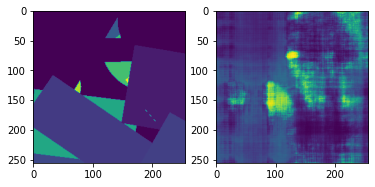

In [17]:
model.eval()
pred = torch.zeros((256,256))
for i in range(256):
    for j in range(256):
        #print(model(torch.tensor([[i/256,j/256]])).shape)
        pred[i,j] = model(torch.tensor([[i/256,j/256]]))[0,1]

plt.subplot(1,2,1)
plt.imshow(a.color_map)
plt.subplot(1,2,2)
plt.imshow(pred.detach().numpy())
plt.show()